In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import glob
from scipy.signal import convolve2d
%matplotlib inline

In [2]:
filepath = '/home/hasitha/Desktop/full_width_tube/'
filename = 'recon_full width_'

In [3]:
def image_normalization(img, L):
    """
    img: np.ndarray:
    L  : power of 2
    """
    _min, _max = img.min(), img.max()
    img = ((img-_min)/(_max-_min)*(L-1)).astype(np.uint8)
    return img

In [4]:
def image_histogram(img, L, disp=False):
    img = image_normalization(img, L)
    out = np.zeros(L)
    for i in np.arange(L):
        out[i] = np.sum(img==i)
    if disp:
        plt.figure(figsize=(8,8))
        plt.bar(np.arange(L), out)
        plt.title('image histogram, L = {}'.format(L))
        plt.show()
    return out

In [5]:
# this does not give better result, do not use it
def histogram_equalization(img, L, disp=False):
    img = image_normalization(img, L)
    hist = image_histogram(img, L)
    mapping = np.zeros(L)
    for i in np.arange(L):
        mapping[i] = int((L-1)*np.sum(hist[:i+1]))
    mapper = np.vectorize(lambda x: mapping[x])
    out = mapper(img)
    out = image_normalization(out, L)
    
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(out, plt.cm.gray)
        plt.title('image after equalization')
        plt.show()
    return out

In [6]:
def gaussian_kernel(size, sigma=None):
    assert size%2 == 1 and size > 0, 'size must be odd positive integer' 
    if sigma == None:
        sigma = size // 6
    center = size//2
    kernel = np.zeros((size, size))
    for i in np.arange(size):
        for j in np.arange(size):
            diff2 = (i-center)**2 + (j-center)**2
            kernel[i,j] = np.exp(-diff2/sigma**2/2)
    out = kernel/np.sum(kernel)
    return out

In [7]:
def unsharp_mask(imgs, size, sigma, K, N):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    sharpened = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img    = image_normalization(img, 256)
        kernel = gaussian_kernel(size, sigma)
        blur   = convolve2d(img, kernel, mode='same', boundary='symm')
        mask   = img - blur
        mask   = image_normalization(mask, K)
        out    = img + N*mask
        sharpened[i,:,:] = image_normalization(out, 256)
    return sharpened

In [8]:
def image_binary(imgs):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    binaries = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img = image_normalization(img, 256)
        hist = image_histogram(img,256,True)
        sorted_hist = np.argsort(hist)
        print(sorted_hist[::-1][:5])
        hist[hist==0] = np.inf
        clf = np.argmin(hist[70:100])+70
        print("the {}-th image, has min {}".format(i,clf))
        binary = img > clf
        binaries[i,:,:] = binary
    return binaries

In [9]:
mask = np.zeros((300,300))
for i in np.arange(300):
    for j in np.arange(300):
        mask[i,j] = -1e10 if (i-150)**2 + (j-150)**2 > 150**2 else 0
        
full_img = np.zeros((900, 300, 300))
for i in np.arange(900):
    file = filepath + filename + '{:05d}'.format(i+400)+'.tif'
    img  = tif.imread(file)
    full_img[i] = img[800:1100,800:1100] + mask

full_img[full_img < 0] = 0

for i in np.arange(900):
    full_img[i] = image_normalization(full_img[i], 256)

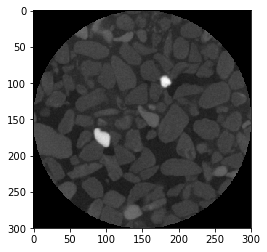

In [10]:
plt.imshow(full_img[20],cmap='gray')

In [17]:
def image_binary(imgs):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    binaries = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img = image_normalization(img, 256)
        hist = image_histogram(img,256)
        sorted_hist = np.argsort(hist)[::-1]
        print(sorted_hist)
        mark1 = sorted_hist[1]
        mark2 = 0
        ii = 1
        while True:
            sh = 15 if ii < 10 else 20
            if sorted_hist[ii]-sorted_hist[ii+1] > sh:
                mark2 = sorted_hist[ii+1]
                break
            else:
                ii += 1
        print('mark1 = {}, mark2 = {}'.format(mark1, mark2))
        hist[hist==0] = np.inf
        clf = np.argmin(hist[mark2:mark1])+mark2
        print("the {}-th image, has min {}".format(i,clf))
        binary = img > clf
        binaries[i,:,:] = binary
    return binaries

In [18]:
binary = image_binary(full_img)

[  0 100  98  97  99 101  96 102  95 103  94 104  93 105 106  92  91 107
  90 108  71  69  68  89  70  67  51  66 109  72  88  73  52  64  65  87
 110  50  53  54  75  49  76  77  74  86  84  78  85  48  55  79  81 111
  63  83  56  80  82  57  62  58  47 112  60  61  59  46 113 114  45 115
 116 117 118 120  44 119 125 121 122 124 127 126 123 131  43 128 133 130
 129  42 136 132 135 138 134 139 137 143 144 141 140 142  41 146 147 145
 153 148 149 150 152 151 157 163 161  40 154 156 158  39 155 164 160 159
 162 165  38 166 169  37  35 167 170 171 168  36 173 211 209 240 234 223
 172 255 182 184 181 174 176 177  29  30  31  32  33  34 254 175 178 244
 179 180 253 252 251 250 249 248 247 246  28  27  26  12   1   2   3   4
   5   6   7   8   9  10  11  13  25  14  15  16  17  18  19  20  21  22
  23  24 245 187 243 201 212 185 210 186 208 207 206 205 204 203 202 200
 188 199 198 197 196 195 194 193 192 191 190 189 213 214 215 216 241 239
 238 237 236 235 183 233 232 231 230 229 228 227 22

[  0  77  79  78  76  80  75  74  81  82  73  83  72  71  43  44  84  42
  54  46  57  45  55  41  52  53  85  70  56  47  49  51  69  58  59  40
  48  50  60  65  68  61  67  86  62  63  64  66  39  87  88  38  89  90
  37  91  36  92  93  94  95  96 114 115  35 116  98  97 113 109 112 111
 110 117 106 100 108 107 124 119  99 101 125 118 102 104 103 120  34 127
 123 105 121 128 126 122 129 130  33  32 131 132 134 208 214 205  31 136
 191 223 244 133 243 181 168 175 157 249 248 231 148 240 188 234 216 143
 232 220 218 190 187 192 183 207 195 202 203 204 179 209 210 221 251  30
  29 180 165 155 150 163 151 159 156 172 135 145 170 146 222 224 147 233
 229 219 144 217 215 226 235 230 213 236 241 153 245 246 158 160 161  28
 141 255 212 200 182 176 184 173 189 171 169 193 194 167 196 197 199 186
 139 201 164 166 137 138 140  20  19  18  17  21  16  15  14  22 228  12
  13  24  11  10   9   8   7   6   5   4   3   2   1  23 142  25 154 198
 177 227 225 237 238 239 152 242 254 206  26 247 25

[  0  66  67  65  68  69  64  70  63  71  62  72  61  73  60  47  46  48
  49  59  74  45  50  51  58  44  52  55  54  56  36  57  53  75  43  34
  35  37  42  33  41  38  76  39  40  32  77  78  31  79  30  80  81  29
  82  83  84  96  28  98  97  95  94  85  86  99 100  87  92  91  27 101
  93  90  88 102 103 107 104 106  89 105 110 108 109  26 111  25 228 218
 112 221 220 226 224 215 229 213 227 225 222 206  24 219 207 212 230 210
 116 223 195 205 204 189 113 186 209 232 161 183 194 214 216 217 176 203
 238 235 242 240 239 142 143 208 198 181 159  22 115 127 179 182 145 146
 187 148 185 184 154 137 177 169 168 167 162 166 192 164 234 119 211 121
 131 231 233 128 246 236 243 114  23 251 247 171 200 180 241 199 188 190
 191 165 202 197 193 117 130 129 139 140 135 144 147 134 151 133 136 124
 123 122 118 196 132 254 237 201 244 253 163 125 138 155 141 157 170 174
 175 255 178 149 152   9  15  14  13  12  11  10   8  17   7   6   5   4
   3   2   1  16  18 126 248 153 160 173 172 245 15

[  0 134 132 130 131 133 135 129 136 128 138 137 127 139 126 140 125 124
 141 142 123 122 143 144 121 145 120  97  90  91  92  93  96  95  94 119
 146  89  98 147  99 118  88 100 148 101 103  87  86 102 117 150 116 109
 149 107  85 110 104 115 114 151 108 106 105  84  70  71  72  83 111 112
 113  68  69  67 152  66  73 153  75  76 154  74  81  82 155  79  78  80
  65  77 156  64  63 158 157 159  62 160 161  61 162 164  60 163  59 167
 165 166  58 198 191 190 196  57 189 193 188 183 194 168 197 170 195 187
 169 200 184 199 192 180 186 171 172 203 175 173 185 174 202 182 176 207
 208 181 201 177 204 206  56 179 211 205 209  55 178 210 213 216 214 212
 215 218  54  53 220 221 219  52 217 222 227 233  50  51 242 234 226 230
 251 240 238 236 223 229 228 225 224 241 235 232 239 248 250  48 245  49
 255 231 243 246 249  13  24  23  22  21  20  19  18  17  16  15  14  12
  26  11  10   9   8   7   6   5   4   3   2   1  25  28  27  29 244 237
 247 252 253  47  46  45  44  43  42  41  40 254  3

[  0 105 107 104 108 106 109 103 102 110 101 111 100 112  99 113  98 114
 115  77  97  75  74  72  71  96  76 116  73  78  80  79  70 117  95 118
  82  94  69  81  93  68  84  83  67  92  90  58  87 119  85  66  91  61
  86  89  88 120  62  56  60  59  64  57 121  55  65  63 122  54 123  53
 124 125  52 126  51 127 128 129 130  49  50 131  48 132 134 135 137 133
 147 136 153 139 142 143 149  47 141 138 150 148 156 144 152 151 145 157
 154 146 140 155 159 164 168 158 167 166 162 161 165 160 169 170  45 163
  46 171 173 172 174  44 175 177 214 215 212 211 206 218 210 213 208 205
 203 201 202 178  43 179 194 207 198 188 209 197 200 204 191 221 219 176
 181 182 217 196 192 189 185 186 190  42 199 222 224 229  40 247 246 231
 216 255 180 223 195 193 187 184 183  25  26  20  27  28  29  30  24  31
  23  22  21  19  33  18   1   2   3   4   5   6   7   8   9  10  11  12
  13  14  15  16  17  32 230  34 227 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 226  35 248 249 250 251 252 25

[  0  72  73  74  75  71  70  76  77  69  78  68  79  67  53  80  52  54
  51  66  55  50  81  49  56  64  57  65  58  63  59  48  62  42  60  61
  40  82  41  39  47  43  45  38  46  44  83  37  84  36  85  86  87  35
  88  34  89  90  91  33  93  92 104  96  95 101  94  98 102  97 103 105
 106 100 111 114  99 113 116 115 110  32 108 117 112 107 109 119 118  31
 120 121  30 124 123 122 125 133 231 220 227 204 217 250 228  29 243 240
 206 128 131 229 249 251 194 182 144 230 241 244 245 207 221 155 149 146
 234 209 208 235 205 202 215 199 223 224 226 143 236 188 184 239 129 130
 132 158 135 152 150 145 238  28  27  25 255 196 169 177 178 181 183 186
 187 189 191 254 200 201 211 212 214 218 222 232 233 237 246 247 248 252
 175 127 140 165 156 162 153 151 148 157 167 134 136 137 138 253  26  18
  23  22  21  20  19  24 168  17 242   1   2   3   4   5   6   7   8   9
  10  11  12  13  14  15  16 142 139 141 171 172 173 174 176 166 179 180
 164 163 185 161 160 190 159 192 193 195 197 198 15

[  0  56  57  58  55  54  59  60  53  52  61  41  62  40  39  51  42  43
  44  50  38  45  63  46  49  47  37  48  64  30  29  36  31  28  65  32
  27  33  35  34  66  67  68  26  70  69  71  25  72  80  74  78  73  76
  81  75  79  24  77  82  88  91  84  89  92  83  87  90  93  94  85  86
  95  97  96  23  99  98  22 243  21 242 100 247 251 250 239 189 241 233
 123 219 111 245 234 226 102 119 118 248 101 246 114 106 133 115 141 110
 138 117 249 147 227 206 213 216 186 185 220 170 223 224 172 235 155 158
 237 244 229 228 105 109 214 107 104 240 238 103 218 221 208 236 211 200
 113 202 161 139 137 164 135 134 166 132 131 167 254 174 179 184 122 188
 192 193 195 143 168  20 255 108 199 171 173 175 177 178 180 181 112 191
 197 201 157 205 209 210 212 225 230 231 232 252 253 169 190 129 149 116
 121 124 125 126 128 130 140 144 146 127 150 154 151 152 148  11  19  18
  17  16  15  14  13  12  10 120   9   8   7   6   5   4   3   2   1 162
 165 163 203 183 187 145 194 196 198 142 176 204 18

[  0  54  53  52  55  51  56  50  57  49  38  58  39  40  48  37  36  41
  47  42  35  59  44  43  46  45  60  34  33  61  28  62  29  32  30  27
  31  63  64  26  65  66  25  67  68  24  82  78  77  79  81  69  76  83
  80  71  70  75  74  72  73  84  87  88  85  86  89 255  23  90  91  22
  92  21  93  20 116  94 101 117 211 171 161 124 217 218 200 125 120 222
  97 109 189  95 146 254 138 205 195 206 207 188 160 209 220 102 106 108
 175 170 118 156 131 112 113 119 110 114 191 104 100 130  96 133 153 182
 178 176 223 167 164 213 210 242 193 140 151 208 225 233 232 239 228 227
 186 226 194 248 221 241 197 202 192 244 245 212 204 198 234  98 144 185
 183 177 169 163 162 159 158 157  99 150 148 145 152 134 137  19 135 105
 136 111 139 238 237   1   8   2   3   4 251 250 240   5   6   7  17 236
   9  10  16 243 253 249  18  11  12  13  14 246  15 247 252 187 235 165
 132 141 142 143 147 149 154 155 166 231 168 172 173 174 179 180 181 184
 129 128 126 123 230 229 224 219 216 215 214 203 20

[  0  88  86  87  89  85  90  84  91  83  92  82  81  93  94  80  60  61
  63  62  59  65  64  95  66  58  79  96  67  78  57  77  68  69  97  70
  73  71  75  76  74  98  72  56  55  99 100  54 101  53  51  52  48  49
  50  47 102 103  46 105 104 106  45 107 108  44 109 110 111  43 112 113
  42 115 114 116 117  41 118  40 119 125 121 123 120 124 127 122 126 128
 130 132 129 131  39 135  38 137 136 133 138 145 149  37 148 147 134 142
 139 144 151 153 152 141 140 146 154 143 150  36 155 156 158  35 157 160
  34 184 185 183 178 159 189 165 163 173  31 227 249 187 188 190 237 167
 222 177 171 213 161 162  30 196 224 225 217 232 226 228 229 168 233 234
 235 238 243 246 253  33 208  32 209 255 203 176 179 180 170 181 166 182
 186 191 192 193 194 172 175  14  15   1   2   3   4 169 254   5 164   6
   7  29  28   8  27  26  25  24   9  10  23  11  12  13  21  20  19  18
  17  16  22 207 174 252 201 202 223 204 221 220 219 218 205 216 215 214
 206 212 211 200 199 198 242 210 250 248 247 245 24

[  0  71  72  70  73  69  74  68  75  67  76  66  50  51  49  48  52  65
  77  53  47  78  64  54  55  56  46  79  57  63  62  61  80  59  58  60
  45  81  44  82  83  43  42  39  84  38  40  41  37  85  36  86  87  35
  88  34  89  91  93  94  92  90  95  98  33  96  97  99 100 101 104 103
 102  32 105 107  31 106 177  30 174 179 173 109 108 113 115 133 175 172
 110 120 168 181 178 171 170 164 114 119 117 129 176 121 166 111 124 169
 186 131 130 180 182 126 163 118  29 184 162 167 160 165 112 134 183 132
 152 122 123 125 159 156 158 185 155 187 127 154 188 128 161 145 153 136
 142 146 116 137 138 140 151 144 189 141 135 143 190 191 157 149 139 150
 148 147 192 194  28 198 202 209 224 234 223  27 214 238 235 242 247 233
 231 227 249 215 221 219 218 216 255 201 195 211 193 210 197 205  20  16
  17  18  19 213  21  22  15  24  25  26  23  14 252  13  12  11  10   9
   8   7   6   5   4   3   2   1 253 196 251 250 212 220 222 208 207 225
 226 206 228 229 230 232 204 203 236 237 200 239 24

[  0  79  78  76  77  75  80  74  81  73  82  72  83  55  54  71  56  53
  57  84  52  58  70  85  59  51  69  60  61  68  86  50  62  67  65  64
  66  63  87  49  88  48  89  42  47  41  40  90  43  46  44  39  45  91
  38  92  37  93  94  95  36  96  97  35  98  99  34 100 116 101 119  33
 117 198 102 196 202 121 118 107 197 103 123 114 199 113 120 194 122 112
 105 108 192 106 115 201 191 104 193 200 203 187 195 190 111  32 110 128
 109 124 125 126 127 188 189 204 171 205 179 184 181 183 174 180 186 185
 206 176 136 175 177 178 155 156 182 147 138 166 154 207 129 130 133 158
 173 163 167 208 169 168 213 211 151  31  30 157 164 140 137 144 146 148
 141 165 212 153 159 160 170 162 149 152 145 172 216 131 210 139 215 228
 142 209 161  28 134 132 244 240 232 230 135 218 217 143  29 235 234 237
 238 227 247 222 220 219 245 250 243 242 249 214 255 150 236 233 229 226
 224 223  16  15  14  13  12  11  10   9   7   8  18   6   5   4   3   2
   1  17 239  19 221 231 246 248 225 251 252 253 25

[  0  92  91  93  90  94  89  95  88  96  87  97  86  98  64  85  65  63
  67  62  99  66  61  84  68  69 100  60 101  59  70  83  71  82  72 102
  75  74  80 103  81  76  58  73  79  78  77 104  57 105  56 106 107  55
 108  54 109  53 110 111  50  51  52  49 112  48  47 113  46 114 115  45
 116 135 117 137 119 118 138 139 136  44 134 132 121 128 133 131 125 130
 127 120 129 124 122 123  43 140 142 126 141  42 143 234 235 239 145 233
 144 228 232 146 238 241 236 229  41 240 231 237 230 148 225 147 149 242
 227 226 150 152 224 151 243 215 153 220  40 207 216 221 217 213 223 245
 210 212 244 218 219 222 214 203 157 205 204 206 183 197 173 201 182 246
 209 160 196 156 211 247 199 180 184 154 162 208  38 181 159 186 185 163
 188 194 202 200 187  39 179 190 155 191 170 195 161 198 164 193 175 158
 165 178 166 174 167 171 168 169 177 176 248 249 192 251  37 189  36  34
  35 255 250 172 253   8  15  14  13  12  11  10   9   7  17   6   5   4
   3   2   1  16  18 252  27  33  32  31 254  29  2

[  0  87  88  86  89  85  90  84  91  83  92  82  93  61  81  94  62  60
  63  59  64  95  58  80  65  66  57  79  78  67  96  68  56  77  97  69
  70  71  73  74  76  72  75  98  55  99  54 100 101  53 102 103  52 104
 107 105 106  51 108 109  50 110  49  48 111 130 131  46 112 127 129 133
  47 128 114 132 126 124  45 119 122  44 115 134 117 116 118 123 113 125
  43 121 120 135  42 136 137  41  40 138  39 228 231 227 221 139 229 230
 197 222 211 219 223 225 199 224 191 212 220 226  38 195 203 186 196 209
 189 207 194 208 201 184 233 217 210 206 140 214 218 215 204 141 176 200
 235 205 213 202 216 234 198 185 180 190 147 179 232 159 169 182 165 143
 142 187 188 178 172 175 153 192 237 236 167 193 144 151 152 161 163 183
  37 173 181 171 162 166 174 158 148 168 155 177 145 238 146 170  35  36
 156 150 149 160 157 240 164 255 154 247 242 239  10  20  19  18  17  16
  15  14  13  12  11 251   9  22   8   7   6   5   4   3   2   1  21  24
  23 252 250 253 248 246 245 244 243 241 254  34  3

[  0  54  53  52  55  51  56  50  57  37  38  36  58  39  49  35  40  41
  48  59  42  34  47  43  44  46  60  45  33  61  32  62  63  31  30  64
  78  65  66  67  77  79  29  68  80  69  28  76  70  71  72  81  75  74
  73  27  82  26  83  25  84 137 138 140  85 139 141  24 135 143 136 142
 133 134 132 126  86 144 131  87 125 122 130  23 127 124 109 116 119 129
 128 111 112  98 145  22  93  92 146 107 118  88 123 121 117 113  94 102
 115 104  89  96 255 106 103  95 120 100 114 110  90 105 147  99 148 101
  91 254 152  97 196 168 197 164  21 201 205 158 226 225 157 216 155  20
 149 171 248 174  11 251  17  18 238 237 236 250 235 234 233 231 232 240
 230 229 228 227 252 253 224 223  19 222 239 242 241  12  10 246 220   9
  13   8  14   7  15   6 247   5   4   3   2  16   1 249 245 244 243 221
 170 219 186 184 183 182 181 180 179 178 177 176 175 173 172 150 151 153
 154 156 159 160 161 162 163 165 166 167 185 187 218 188 217 215 214 213
 212 211 210 209 208 207 206 204 203 202 200 199 19

[  0  72  73  71  70  74  75  69  76  68  50  77  49  51  67  52  48  53
  66  78  47  54  79  55  65  56  46  80  64  57  62  63  58  61  59  60
  45  81  82  44  83  84  43  85  96  86  87  97  94  95  90  99  89  42
  92  98  88 101  93  91 102 100 103 104  41 105  40 106  39 107  38 109
 108  37  36 110  35 111 112  34 114  33 113 115  32 117 116  31 120 232
 118 220 149 225 207 226 227 228 122 235 173 223 221 208 206 163  30 154
 159 180 126 212 222 229 230 234 119 121 124 127 245 136 215 231 179 238
 157 153 137 200 182 209 211 160 218 143 156 236 146 150 125 170 130 233
 131 184 183 244 224 219 187  29 193 242 241 147 140 142 151 152 158 129
 138 128 249 217 148 214 145 210 123 198 134 194 135 162 177 155 175 237
 172 161 167 243 246 248 251 216 250 203 199 178 133 197 196 201 139 141
 171 165 181 168 186 202 240 164 166  28 239 132 213 176 204 190 191 192
 205 189 254 174 252 255 247 144 188 185   7  12  11  10   9   8   6  14
   5   4   3   2   1  13  16  15 195  17  18  19  2

[  0  78  77  79  80  76  81  75  82  74  53  54  55  83  56  52  73  84
  57  51  72  58  85  59  50  71  70  60  86  61  49  68  69  67  64  62
  66  48  65  63  87  88  89  47  90  91  46  92  94  93  97  96  95  45
 105 108  98 100 101 103 107 109  99 104 106 102  44 110 111 112  43  42
  41 113 114  40 115 117 116  39  38 118 119 121 120 122 123 124 125  37
 130 127 131 129 126 128 132 134 133  36  35 135 137 136 138  34 183 141
 149 153  33 158 139 165 217 222 221 241 246 146 193 150 160 154 155 188
 162 189 187 210 216 219 203 207 163 220 223 227 231 234 238 244 250  32
  30  29 184 255 171 145 167 147 157 164 148 161 180 174 159 151  31 156
 152  28 182 252 253  26 251 249 248 247 245 144 243 242  27  25 240  24
   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23 143 237 239 197 175 206 205 204 176 202 201 200 199
 198 196 173 195 194 177 192 191 190 178 179 186 185 208 211 142 226 181
 236 235 140 233 232 230 229 228 254 225 212 224 16

[  0 135 139 138 136 133 137 134 132 141 140 131 142 130 143 144 129 145
  94  97  96 128 127  95  93 146  92  98  91  99 126  90 100  89 147 101
 103 125 102 124 148  88 123 105 104  87 149 106 122 107 121 150 108 109
 111 120 117 118  86 151 119 114 115 110 112  85 113 116 152 153  84 154
 155  83 156 157 159 160 158 163 162  82 161  81 164 168 166 165 169 171
 167  80 172 173  79 170 175 174 176 180  78 177 178 179 181 185 182 186
 183 199 184  77 204 191 192 202 200 205  76 198 196 197 195 189 194 201
 203 190 193  75 188 206 187  73 208 207  74 211 209  72 210  69  70  71
  68 212 214 233  67 216 215 217 218 213  66 230 231 229 226 234 223  64
 227 235 221 237  65 225 236 232 228 224 219 239 220 238  63  62 222 241
 240 243  60  61 245  59  58 242  57  56  55  54  53 255 247 246   6  15
  27  26  25  24  23  22  21  20  19  18  17  16  13  14  12  11  10   9
   8   7   1   2   3   4   5  29  28 253  30  31 251 254 250 249 248 244
  52  51  50  49  48  47  46  45  44  43 252  41  4

[  0  63  64  65  62  66  61  67  60  68  44  45  43  46  59  69  47  48
  42  58  49  41  70  57  50  51  55  56  52  54  53  71  40  72  39  73
  74  75  38  76  78  77  79  37  80  92  81  91  93  94  95  90  86  36
  96  83  82  89  85  87  84  88  97  98 100  99 101 102 103 104  35  34
 105 106 109 108  32  33 111 110 107  31 113 112  30 239 236 150 242 245
 218 115 235 227 243 145 182 247 197  29 234 119 139 123 148 117 233 191
 232 228 223 221 220 217 206 114 116 120 132 124 126 128 131 127 179 205
 202 212 201 159 158 157 214 219 153 222 151 170 225 146 226 229 136 181
 134 183 135 187 189 190 246 244 192 196 231 207 130 198 204 133 209 211
 213 180 224 230 237 241 248 250 252  28  27 215 199 255 154 165 164 163
 162 161 155 152 168 147 143 142 138 122 137 166 125 175 169 171 172 174
  11  24  20  21  22  23  25   3   5   2  26   1 129   4  18  19  12   6
  17   7  16  15   8   9 254  13  10  14 178 253 208 184 185 186 176 188
 173 193 194 195 200 167 203 210 251 160 156 216 14

[  0  59  58  57  60  61  56  62  55  41  40  42  39  63  54  43  44  38
  64  53  45  52  46  37  47  65  50  48  51  49  66  36  67  68  35  69
  70  71  72  34  73  74  33  87  75  85  84  86  88  83  76  82  89  81
  79  78  77  32  92  90  93  91  80  94  95  31  97  96  98  99 103  30
 100 101 102  29 105 222  28 223 116 104 209 243 120 107 106 147 128 167
 185 186 214 228 226 184 109 126 124 122 140 144 225 146 112 220 152 227
 230 238 200 194 161 190 110 118  27 121 130 108 127 201 229 208 166 213
 215 162 160 159 153 219 204 191 189 192 178 137 136 129 135 165 168 195
 169 212 211 173 207 206 158 224 141 148 142 181 235 231 115 218 113 111
 177 179 187 199 154 133 203 202 216 217 221 236 237 240 242 247 249 251
 252  26 197 134 170 143 119 145 114 149 150 123 155 156 163 164 117 172
 138 125 180 188 193 246 244 248 250 131  25 139 239  24 196 245 234 175
 233 198 183 182 176 205 255 174 171 210 157 151   7  11  10   9   8   5
   6  13   4   3   2   1  12  16  14  15  17  18  1

[  0  61  60  62  63  59  64  58  57  65  43  44  42  41  45  56  66  40
  46  55  39  47  67  48  54  49  68  50  38  53  51  52  69  70  37  71
  36  72  35  73  74  75  34  76  87  83  84  88  33  78  77  80  90  79
  81  85  86  89  82  91  32  92  94  93  31  97  96  95  30  98  99 100
  29  28 102 101 193 104 195 194 103 190 189 105 192  27 186 106 187 191
 197 200 196 199  26 184 130 188 150 182 171 172 183 181 160 120 214 211
 208 201 180 179 165 178 176 129 169 134 123 240 109 108 152 161 185 155
 158 159 244 168 153 177 249 198 205 217 246 175 173 170 207 166 163 209
 212 213  25 142 110 116 111 144 121 145 119 229 112 167 206 227 226 251
 218 242 238 140 117 126 237 202 143 136 164 118 132 245 250 241 243 252
  24 230 107 114 225 220 219 215 174 233 151 149 148 235 236 138 137 131
 128 124 122 154 255 247 210 253 248 239 234 232 231 228 224 223 222 221
 216 127 204 141 203 125 133 135 139 146 147 156 157 162   6  10   9   8
   7   2   5   4   3  12   1  11  18  13  14  15  1

[  0  70  69  68  71  72  67  66  73  65  74  49  50  48  51  47  64  75
  52  53  46  63  76  54  55  62  77  56  45  61  60  58  57  59  78  44
  79  43  80  81  42  82  83  41  84  40  85  86  87  39  89  38  91  88
  95  96  97  92  90  94  37  93  98  99  36 115 100 101 114 102 113 118
 117 116 103 112 111  35  34 119 104 105 108 109 106 107 110 120  33  32
 121 122  31  30 123 154  29 159 124 151 163 161 140 148 157 153 156 164
 131 128 141 142 152 150 147 162 146 187 172 158 168 171 155 129 167  28
 166 190 139 165 181 183 185 241 144 160 138 133 136 230 202 240 198 242
 245 192 149 186 126 135 184 134 180 226 174 130 254 212 255 125 206 210
 214 215 216 217 219 220 222 223 132 231 232 233 236 237 248 251 252 253
 209 228 143 196 175 145 182 188 189 193 195 170 197 199 178  23  22  16
  24  21  20  25  19  26  27 137  18  17 200  15  14  13  11  10   9   8
   7   6   5   4   3   2   1  12 244 250 225 203 204 205 207 208 211 213
 194 191 218 221 179 224 227 249 229 177 176 234 23

[  0  53  52  54  51  55  50  56  37  38  49  36  39  35  57  48  40  41
  34  47  42  58  46  45  43  44  33  59  32  60  61  31  62  63  64  30
  65  68  66  67  29  69  70  71  72  87  28  73  74  75  85  88  76  86
  27  77  84 255  89  79  78  83  80  82  90  26  81  25  91  92 131  93
  24 119  95 100 129 133 139 132 128 140  97 135 117 127  96  23 114 134
 142 143 150 112 116 125  94 109 111 107 113 148 124 136 137 138 106 126
 120 118 205 123 145 144 121 105 141 115 101 147  99 122 217  22 108 208
 196 104 110  98 178 146 130 190 245 102 244 171 172 216 215 199 168 213
 181 189 206 183 185 186 103 169 167 149 151 164 222 152 234 157 243 155
 248 251 250 235 249 246 247 236 237 238 239 240 241 242 253 252 254 191
 192   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20 232  21 195 194 193 233 218 231 230 200 198 180 179 177 176
 175 174 173 170 166 165 163 162 161 160 159 158 156 154 153 201 202 182
 219 229 228 227 226 225 224 223 221 220 214 184 21

[  0  53  54  52  55  51  56  50  38  37  39  36  57  49  40  35  41  48
  58  42  47  43  34  46  44  45  59  33  60  61  32  62  63  31  72  71
  70  73  64  65  69  67  68  30  74  66  75  29  76  77  28  78 255  79
  81  27  80  82  83  85  26  84  86  88  25 170 168 164 167 165 171  87
 157  92  96 153 169 131  95 162 136 127 158 132 166 143 172  93 175  98
  89 142 140  24 223 133  90  94 114 126 123 122 110 144 113 111 101 177
 161 163 159 151 148 119 117 116 115 174 107 160 106 104 103  97 179  91
 193 205 124 180 149 145 154 139 146 156 150 128 186 188  23 185 206 147
 184 208 213 125 198 183 222 248 227 229 230 232 245 234 235 244 243 253
 191 182 102 129 120 118 155 134 173 112 176 109 108 137 138 152 239 100
  99   7 251 249  12   2 247  11 246  10   8   3   1   5 241 242 250   4
  17 252  13 197 199 200  14   9  15  21  20  19  18   6  16  22 207 240
 210 204 203 195 194 192 190 189 187 181 178 201 105 121 254 130 135 141
 209 211 238 212 237 236 233 231 228 226 225 224 19

[  0  74  73  72  75  71  76  70  77  51  69  78  50  52  53  68  49  54
  79  55  67  48  56  66  57  80  47  65  59  58  62  60  64  63  81  61
  46  82  45  83  44  84  85  43  89  86  87  88  90  91  93  95  42  92
  94  41  96  40  97 101  98  99 103 102 100  39 110 111 109 104 106  38
 105 108 112  37 107 119 113 115 114 117 118  36 116  35 120 121 122 124
  34 123 125  33  32 219 222 214 176  31 253 140 130 135 189 158 152 230
 132 229 228 221 218 169 247 199  30 126 254 128 129 131 255 207 213 185
 187 188 190 191 192 195 196 198 204 206 208 211 217 182 227 231 233 235
 236 239 240 241 242 244 245 251 252 184 127 148 166 154 159 151 137 161
 162 163 164 165 147 139 143 146 149 156  24 250 243 141 248 136 142 138
  29  28  27  26 249  25 246  20  23  22   1   2   3   4   5   6   7   8
   9  10  11  12  13  14  15  16  17  18  19 238  21 144 170 237 168 157
 197 160 194 193 186 167 183 181 201 180 179 178 177 175 174 173 172 200
 202 145 150 234 232 171 226 225 224 223 220 216 20

[  0 132 133 134 131 130 135 136 138 129 137 128 127 126 139 140 141  93
 125 142  92  91  95  94 124  96  90  97  89 123 143  99  98 122  88  87
 144 100 121 101 145 103 102 120  86 104 105 118 119 146 106 147 116 117
 107 110 109 108  85 114 148 113 111 115 112 149  84  83 150 151  82 152
  81 153  80 154 156 155 157 160 161 158 164 163  78  79 159 166 162 167
 165  76  75 169  77 168 170  71 174  73 172 171  72  74 173  70 176 190
 183 181 178 177 186 187 188  69 179 191 185 175 180  67  68 194 189 193
 182 184 192 195 197  65  66 196 198 202 203 204 205 200 199 201  63 208
 206  64 207  61 215  62 212 214 209 216 219  60 210  59  58 218 211 217
 222 228 213 223 220  57 224 227  56 240  52 255 235 221 225 245 237  19
  20  21  22  23  24  25 241  26  28  29  30  31  32  33  34  35  27  17
  18   8   1   2   3   4   5   6   7   9  37  10  11  12  13  14  15  16
  36  40  38 244 233 232 231 230 229 226 243 246  39 247 248 249 250 251
 252 253 234 236 238  55 254  41  42  43  44  45  4

[  0  82  81  83  80  79  84  85  78  86  77  58  57  59  56  87  60  76
  61  55  62  75  88  54  63  74  89  64  65  53  73  72  66  71  69  68
  67  90  70  52  91  92  51  93  94  50  95  96  97  49  98  48  99 100
  45  46  42  47 102  41  43 101  44 103  40 105 104 106 108  39 107 118
 112 109 110 115 116  38 114 117 111 113 119 126 120 121 123  37 128 122
 125 124  36 129 127 130 131 132 133  35 134  34 135 137 136 141  33 139
 142 144 166 140 143 173 138 184 196 164 198 145 190  32 149 148 189 183
 181 223 177 176 225 192 231 186 194 235 208 218 150 158 210 156 155 187
 200 199 165 207 221 220 212 211 213 222 160 224 227 228 229 234 237 239
 240 243 245 250 252  31  30  29 241 209 255 182 179 178 174 154 172 170
 169 167 163 254 205 162 161 146 147 180 152 204 193 203 195  12  26   4
  24  25   3  27   2   5  28   1 157  23   6  22  13  21   7  20   8  19
  18  17   9  15  14  10  11  16 206 153 175 159 202 201 197 214 215 216
 217 219 191 188 185 226 230 151 232 233 171 236 23

[  0  66  67  68  65  69  64  63  70  47  46  45  48  62  71  49  44  61
  50  72  51  43  60  52  53  73  59  55  58  54  57  42  56  74  75  41
  76  40  77  78  79  39  80  38  81  36  37  82  35  83  34  33  84  94
  95  32  85  93  86  96  31  97  91  89  92  90  87  88  99  98 100  30
 101 103 105 102  29 104  28 106 107 232 208 254 225 231 226  27 210 230
 246 249 124 221 115 108 110 179 211  26 196 198 139 112 205 207 209 204
 228 223 243 194 117 238 245 121 109 158 183 252 251 229 149 219 236 247
 197 218 138 215 242 216 143 113 213 222 114 217 178 184 188 119 253 233
 132 152 131 153 234 239 248 126 168 162 123 164 141 212 147 174 116 154
 241 220 224 165 146 201 235 182 111 120 122 177 125 181 176 202 185 192
 195 136 137 167  25 255 118 191 170 173 175 180 186 189 190 193 161 128
 200 206 214 237 240 244 169 172 134 148 160 135 133 140 157 155 151 144
 145   2   7   1  12  14  15  16  17  13   3  11   8   4  10   5  19   9
   6  18 199  20 166 129 130 142 150 156 159 163 17

[  0  70  71  72  69  73  68  67  74  75  66  49  50  48  51  76  52  47
  65  53  46  54  77  55  64  63  45  56  57  62  61  78  58  59  60  79
  44  80  43  81  82  83  84  42  85  86  41  87  88  40  39  89  37  90
  38  36  92  91 104 105 100 102 103  34  94 106 107  35 101  93  97  99
  98  95  96 108  33  32 109 111 110  31 112 121  30 142 176 214 243 113
 233 115 170 169 128 237 145 147 225 216 213 203 212 118 116 192 190 182
 175 160 120 119  29 253 246 164 219 187 191 194 199 209 206 232 244 226
 224 173 177 179 185 186 222 238 195 230 205 245 208 162 140 180 148 158
 137 124 135 154 129 211 218 131 221 248 133 251 136 236 239 242 146 153
 159 202 156 166 117 178 157 143 183 184 122 165 193 125 198 126 200 201
  26  28 255 114 188 197 204 207 210 215 217 220 223 227 228 123 231 234
 235 240 241 247 249 250 189 127 181 155 174 254 132 134 138 149 141 161
 172 171   7   4  16  15  14   1  13  12  11   6  10   5   2   3   9  18
   8  17  24  19 144 196 168 167 163 152 151 150 13

[  0  85  84  83  86  87  82  81  88  89  80  90  79  59  61  60  58  91
  57  62  63  78  56  92  77  64  65  55  93  76  67  66  75  54  69  71
  68  74  72  94  70  73  53  95  96  52  97  51  98  99 100  50  49 101
 102 103  47  48 105 104  45  46 107 106  44 109  43 108  42 110 123 111
 112 120 119 113 121  41 115 124 122 118 116 117 125 114 126  40 128 127
 129 130  39  38 133 131  37 132  36 134 135 140 137  35 142 138 148 139
 143 157  34 141 149 196 179 146 160 159 150 202 194 195 175 164 232 177
 213 183 184 189 221 172 203 241 249 162 154 152 151 187 136 246 168 210
 219 214 216 209 205 207 165 225 227 228 229 230 233 235 240 242 244 252
  33 247 211 201 188 163 158 156 153 145 167 170 174 176 178 180 185 255
 199 193 198 192 191  25  20  21  22  23  24  26  18  27  28  29  30  31
  32 200  19 218 161  16   1   2   3   4   5   6   7   8   9  10  11  12
  13  14  15  17 155 206 182 173 234 212 231 215 181 226 237 190 224 223
 222 186 220 236 238 217 204 208 147 253 251 250 14

[  0  70  69  71  72  68  73  67  74  66  48  49  50  51  75  47  65  52
  76  53  46  54  64  45  77  63  55  56  62  57  58  78  61  60  59  79
  44  80  81  43  82  83  42  41  84  38  40  39  37  85  36  86  35  34
  87  88 104 106 103  33 102  99 101  90 105 107  93  91  89  98  95  92
  97 100  96 108  94  32 110 109  31  30 111 112  29 113 114 117 234 138
 140  28 122 119 152 115 196 180 231 243 241 136 239 237 236 227 220 216
 212 206 247  27  25 129 116 124 121 118 130 255 248 147 242 155 156 232
 253 233 251 238 164 175 240 167 246 245 173 223 171 215 197 190 204 137
 219 217 189 198 209 210 211 213 214 222 235 218 230 221 229 228 226 225
 224 135 244  14   1   2   3   4   5   6   7   8   9  10  11  12  13  15
 207  16  17  18  19  20  21  22  23  24  26 252 250 249 208 199 205 203
 161 160 159 158 157 154 153 151 150 149 148 146 145 144 120 143 142 123
 141 125 126 254 128 139 131 132 133 162 163 165 185 202 201 200 134 195
 194 193 192 191 188 187 186 184 166 183 182 181 17

[  0  84  83  85  86  82  87  81  88  80  89  79  60  59  57  61  58  90
  78  62  91  63  56  77  64  55  65  92  76  67  93  75  66  74  72  73
  69  54  68  71  70  94  95  53  96  97  52  98  51  99 100  50  46 101
  47  48 102  49  44  45  43 103  42 104 105 106 107 108  41 111 112  40
 109 110 113 116 115 139 114 137  39 141 140 117 124  38 118 126 138 135
 123 134 131 132  37 119 143 121 142 133 122 125 120 128 136 127 130 145
 144 129  36 147 151 146 148 150 152 162 149 155 154 158 174 238 163 165
 153 198 175 180 183 185  34 220  31 173  35 237 216 172 168 156 159 160
 161 171 166 167 255 170 184 251  28  29  30 176  32  33 157 177 178 253
 252 250 179 249 248 247 246 245 244 243 242 241 240  27  26  25  24   1
   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23 239 254 169 236 208 207 206 205 204 203 202 201 200 199
 182 197 196 195 194 193 192 191 190 189 188 187 186 209 210 211 224 235
 234 233 231 230 229 228 227 226 225 223 212 222 22

[  0  67  66  65  68  64  69  63  70  62  71  47  46  61  45  48  49  44
  72  60  50  51  43  73  59  52  53  42  55  58  57  56  54  74  75  41
  76  40  77  78  79  38  39  80  37  35  81  36  82  34  83  84  33  85
  32  87  89  86  90  92  93  88  91  96  95  94  98  97  31 100  99 108
 102 103 101 104  30 109 110 107 106 111 105 114  29 117 112 121 118 116
 236 120 122 115 119 113 214 123 234 217 208 219 228 222 197  28 186 229
 239 209 226 233 166 215  27 201 224 221 193 207 206 237 223 210 230 212
 175 168 202 220 192 169 178 162 188 191 194 232 196 238 235 172 126 140
 246 127 151 231 185 189 176 195 167 164 158 156 205 211 147 218 227 182
 141 128 245 242 133 138 187 125 160 171  26 170 131 163 181 161 130 199
 240 157 204 150 213 216 225 144 190 200 249 198 243 184 250 241 124 154
 129 143 145 146 148 149 152 136 180 254 165 177 179 137 134  25  24 244
 183 251 139 159 174 255 142 247  13  12  11  10   9   8   7  15   6   5
   4   3   2   1  14  16 248  17 135  19  20  21  2

[  0  91  90  89  88  92  87  93  94  86  85  95  64  65  63  96  62  61
  84  66  67  68  97  60  83  69  82  59  70  98  81  72  71  79  73  80
  58  74  99  78  77  76  75 100  57 101  56 102  55 103  54 104 105  53
 106 107  52  51 108 109 110 118  49  50 111 116 113 114 119 124  47  48
 115 120 127 125 121 123 112 128  46 137 117 122 134 131 140 130 132 129
 138 135 133 126 136 139 142 141  45  44 143 144 145  42  43 146 147 148
  41  40 150  39 151 195 197 235 155 157 232 186 149 221 219 204 207 230
 229 228 213 234 153 236  37 158 209 159 171 222 168 170 218 199  38 216
 205 223 226 231 160 181 156 184 227 210 253 220 241 242 217 233 244 214
  36 225 255 166 174 154 152 191 192 193 196 167 201 202 203 178 251 161
  34 162 243 245 248 252 173 164 211 177 176 239 172 240 179 238 187 212
 206 215 200 198 224 190 189 188 180 182 250  11  21  20  19  18  17  16
  15  14  13  12  10  23   9   8   7   6   5   4   3   2   1  22  24 249
 208 165 185 247 169 194 246 183 175 163  35  25 25

[  0  86  88  87  89  85  90  84  91  92  83  93  82  60  61  62  63  94
  59  81  58  64  65  95  57  80  66  96  79  56  67  69  68  78  97  77
  72  55  71  70  73  76  74  75  98  54  99 100 101  53 102 103  52 104
 107 105 106 108  51 109 110 112  50 111  49 117 113 114 118 115 116 119
  48 121  47 120 123  46 122 124 125  45 126  44 128 127 129  43 130  42
 134 132 131  41 179 135 133  40 138 154 170 222 227 142 176 160 165 146
 136 236 167  38 184 163 161 237 218 246 194 174 228 243 156 203 230 188
 235 233 171 191 231 238 196 198 202 209 210 217 216 183 215 145 247 148
 152 250 180 248 143 153 139 137 155 158 214 173 242 164 224  39 220 223
 240 253 225 226 229 245 232 244 241 169 213 168 193 162 159 212 150 149
 147 144 140 181 182 185 186 192 157 255 211 205 204 199 201 208  17  18
  19  20  21  15  22  23  24  25  26  27  16  13  14  29  12  11  10   9
   8   7   6   5   4   3   2   1  28 195  30  31 189 234 187 197 200 239
 178 177 175 172 254 141 249 206 251 252 221 207 15

[  0  86  87  85  84  88  83  89  90  82  91  81  80  92  60  61  59  62
  79  58  63  93  57  65  56  64  78  94  66  67  77  55  76  95  74  69
  75  68  70  73  54  71  72  96  53  97  98  99  52  51 101 100 102  50
 104 103  49 105 106  48 107  46 108  47  45 111 109 110  44 112 113 118
  43 138  42 137 114 140 121 119 120 122 133 117 116 123 124 135 115 125
 139 142 129 128 126  41 132 136 134 141 143 131 130 144 145 127  40  39
 248 245  37 251  38 147 242 240 249 146 241 244 250 149 238 232 246 247
 239 226 218 179 150 253 148 234 225 183 222 168 243 208 209 210 211 215
 216 231 201 223 197 229 170 214 152 252 172 164 235 163 160 237 158 154
 156 213 217 221 233  36 224 236  34 227 228 230 220 212 169 186 185 181
 180 178 173 254 190 167 162 207 159 157 153 187 255 202 204 192 205 200
 199 195 196 198  17  15  16  19  18  13  20  21  22  23  24  14 189  12
  11  26  10   9   8   7   6   5   4   3   2   1  25  31  27  28 191 193
 184 182 194 177 176 175 174 171 166 165 203 219 15

[  0  61  60  62  63  59  64  58  65  57  43  42  44  41  66  45  56  46
  40  67  55  47  54  48  39  68  49  52  53  50  51  69  38  70  37  71
  72  36  73  35  74  75  34  33  76  32  77  31  78  30  79  81  86  84
  87  80  83  82  85  29 100  97  98  99  89  90 101  91  95  88  28  93
  92  96 102  94 103 104  27  26 106 105 203  25 225 205 246 247 243 107
 250 134 235 234 228 222 212 170 108 110 112 114 120 254 149 127 214 181
 206 216 152 197 218 220 233 208 240 171 249 172 179 174 169 201 198 175
 176 148 189 188 187 209 184 185 150 210 236 253 252 248 242 241 239 238
 237 232 211 231 227 224 221 217 215 166 213 167 192 255 126 113 153 111
 143 156 109 157 122 115 129 138 131 136 244 147 146 251 145 144 245 139
 151 140 137  24 142 141 135  21  23  22   1   2   3   4   5   6   7   8
   9  10  11  12  13  14  15  16  17  18  19  20 229 230 165 133 158 154
 191 190 155 186 183 182 180 178 194 177 159 160 161 173 162 163 164 193
 195 226 121 132 223 168 219 128 125 124 123 119 19

[  0  58  57  56  59  60  55  61  54  40  41  39  62  42  53  43  38  52
  63  44  37  45  64  51  46  50  47  48  49  36  65  66  35  67  34  68
  33  69  32  31  70  30  71  29  28  72  73  74  27  75  90  91  88  93
  26  87  92  76  86  78  94  81  85  89  82  80  79  84  83  77  95  25
  96  24 113  97 106 248 224 126  98 225 112 108 100 124 228 236 242 169
 152 207 202 142 250 107 145 146 197 105 204  23 206 153 253 208 190 159
 241 239 222 164  99 235 234 117 123 120 118 109 114 111 110 102 101 127
 193 230 223 221 219 150 154 214 162 163 165 200 199 171 194 173 176 147
 217 231 252 133 244 247 249 130 135 245 238 233 232 191 201 189 251 195
 246 188 184 128 205 229 210 211 212 243 215 216 240 182 237 226 227 183
 255 157 161 119 134 116 125 138 139 141 144 104 103 151 156 158 160 131
 170 167 168 172 178  11   6  21   5 254  22   7   4   3   2   1  20   8
  19  12  18  17  16  15   9  14 132  10  13 181 140 122 203 179 185 186
 187 177 175 192 174 196 198 166 209 121 213 155 14

[  0  65  67  66  68  64  69  63  70  62  71  61  46  72  47  45  44  48
  49  60  73  50  43  59  51  58  74  52  42  57  54  53  55  56  75  76
  41  77  40  78  79  80  39  81  82  38  83  84  37  85  36  35  87  86
  34  88  89  90  33  92 106 105  32  31 102  91  95 103  98 104 100  30
 101 108  94 107  97  99  93  96 110 109  29 112  28 146 149 114 135 142
 140 137 147 128 123 118 111  27 129 130 133 134 136 152 150 139 119 132
 125 144 126 122 127 145 154 143 141 117 157 131 115 116 120 121 124 148
 151 153 195 113 156  24 138  25 207 210 212 214 217 250 218 219 233 174
 242 245 247 249 188 255 158 155 170 168 161 175 253 251 159 160 248 254
 246 244 243 162 241 240 239 238 237 236 235 234 163 232 231 252  26 229
  11   1   2   3   4   5   6   7   8   9  10  12  23  13  14  15  16  17
  18  19  20  21  22 230 228 176 173 198 197 196 172 194 193 192 191 190
 189 187 200 186 185 184 183 182 181 180 179 178 177 199 201 227 216 226
 225 224 223 222 221 220 164 165 166 215 202 167 21

[  0  89  90  88  91  87  92  86  85  93  94  84  95  62  83  96  63  65
  64  97  61  66  82  60  67  59  69  68  81  98  80  58  79  70  99  71
  72 100  74  77  73  57  78  76 101  75 102  56 103 104 105  55 106 107
 108  54 109 110 111 112  53 114 113 115  52 123 116 118 117 120 121 125
 119  51 124 122 127 126 137 128 133 129  50 138 131 135  49 136 134 139
 140 130 132  48 141 142 143  47 234 235  46 227 232  45  43 226 145 146
 209 233 238 237 213 220 224 230 211 147 203 201 210 196 144 218  44 242
 229 193 174 183 241 178 217 221 240 216 228 219 198 236 215 149 231 189
 223  42 205 160 154 239 244 191 214 171 172 208 181 197 185 202 199 187
 192 162 163  39 195 167 188 222 151 247 207 148 177 200 173 175 204 170
 243 159 176 190 157 194 180  41 184 168 186 182 245 150 212 225 166 165
 155 156 161  40 179 169 206 248 153 164 246 249 158  38  36  35 255 250
   9  17  16  15  14  13  12  11  10   8  19   7   6   5   4   3   2   1
  18 253 252  21 251  37 254 152  34  33  32  31  3

[  0  65  66  67  64  68  63  69  62  46  47  45  70  61  48  44  49  71
  43  60  50  59  51  72  52  42  58  53  54  55  57  73  56  74  41  75
  76  77  40  79  78  80  81  82  39  83  84  85  38  86  88  90  92  87
  89  91  95  96  93  37  94  98  97  99 102 106 107 100 108 105 101 103
 110  36 104 109 111 178 172 113 112 171  35 173 170 168 166 162 167 163
 169 179 139 143 161 175 176 174 155 154 153 151 164 142 160 165 150 177
 133 156 152 158 114 159 120 121 149 138 157 115 180 182 147 148 136 122
 181 146 144 141 131 130 125 126 119 137 145 129 123 135  34 140  33 183
 134 118 132 116 117 128 127 184 186 124 185  32 187 205  31 248 246 236
 233 224 222 221 211 255 195 198 194 192 189 197 191 252  21  22  23  24
  25  26  27 251  29  30 190 188 249 250 253  28 199  20   9   1   2   3
   4   5   6   7   8  10  19  11  12  13  14  15  16  17  18 247 243 245
 196 219 218 217 216 215 214 213 212 210 209 208 207 206 204 203 202 201
 220 223 244 225 200 242 241 240 239 238 237 235 25

[  0  79  80  81  82  78  83  77  84  55  76  56  54  57  58  53  85  75
  59  60  86  52  74  61  87  51  73  62  63  88  72  50  71  64  66  65
  70  69  68  89  67  90  49  91  92  93  48  94  95  96  47  97  98 100
  99 103 101 102 105 104 106 107  46 108 110 109 112  45 111 114 113 115
  44 116 118 119 131  43 137 133 117 134 135 136 120 132 128 130 122 126
 121 210 129 125 202 211  42 138 124 123 139 127 203 207 206 244  41 163
 214 204 245 175 212 242 209 205 198 240 216 141 156 186 164 208 170 194
 150 196 243 213 172 200 154 155 247 162 145 181 159 160 184 183 182 179
 251 199 161 190 215 171  40 201 193 220 239 140 151 238 152  39 227 149
 233 147 146 232 143 142 224 157 246 166 167 169 195 187 185 241 153 218
 217 192 249 189 250 176  38 168 165 158 144 148 234 248  37 219 229 228
 222 221 191 236 180 173 174 226 178 223 197 188 177 255 225 231 235 252
   9  17  16  15  14  13  12  11  10   7   8  19   6   5   4   3   2   1
  18  21  20 253 230 254  36  35  34  33  32  31  3

[  0  66  65  67  64  68  63  69  62  70  46  61  47  45  44  48  71  60
  49  43  50  72  51  59  42  52  58  53  57  54  55  56  73  41  74  75
  40  76  77  39  78  79  80  38  81  82  83  37  84  86  87  89  95  88
  85  92  90  98  96  93  97  94  91  99  36 100  35  34 101  33  32 102
 104 103  31  30 120 129  29 128 105 106 133 248 118 119 132 139 131 141
 231 125 121 218 249 192 134 247 107 143 232 145 160 123 225  28 152 109
 181 116 115 138 189 233 111 126 114 113 112 124 255 135 204 162 238 201
 240 197 168 196 195 194 172 242 191 190 177 187 250 180 246 183 244 203
 212 150 137 140 224 142 217 226 215 149 236 186 229 153 209 234 156 228
 227 230 243 241 239 235 237 252 245 251   1   2   3   4   5   6   7   8
   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27 253 222 223 206 221 171 169 167 166 165 164 163 108 110 161 159 158
 157 155 117 154 151 122 148 147 146 254 144 130 170 173 220 174 219 216
 214 213 211 210 208 207 136 205 202 200 199 198 19

[  0  58  57  59  56  60  55  61  54  62  41  40  42  39  43  53  38  44
  63  45  46  52  37  47  64  48  51  50  49  65  36  66  67  35  68  69
  70  71  34  72  33  30  32  73  74  29  31  75  76  77  80  28  78  81
  82  85  84  79  86  87  83  88  27  90  89  26  91  92  25  94  93 100
  98 251 250 248 103 101  24  95  97 102 104  96 239 234 106 242 243 244
 245 120 105 152 111 134 190 231 205 246 223 240 237 187 132 247 116 241
 107 236 143 146 229 227 224 221 215 213 197 252 126 108 109 113 121 124
 125 127 171 226 128 163 142 141 164 139 216 206 219 181 228 230 135 232
 235 133 238 151 201 200 129 193 192 194 184 191 196 180 179 178 175 195
 254 199 202 207 208 174 210 211 214 218 220 233 249 253  23 209 186 255
 145 158 155 153 150  99 149 144 160 130 112 122 131 114 119 159 154 161
 162 167 166 165 117 118   9   1   2   3   4 123   5  11  22  21  20  19
  18  12  10  17  16   7  13  15  14   8   6 173 115 136 170 176 177 169
 168 182 183 185 188 189 157 156 198 203 204 148 14

[  0  66  67  65  68  64  69  63  70  46  47  62  71  45  48  44  49  72
  61  50  43  51  60  42  73  52  59  53  58  54  74  56  55  57  75  41
  76  40  77  78  79  39  80  81  82  88  83  86  38  85  84 105 103  87
 106 109 107 104 110 108  91 100  89  90  95 102  37  92 101 111  99  93
  96  97  98 112  94  36 113  35 114  34 115 242 233 231 230 232 234 236
 237 245 240 239 119 244 215 214 228 248 243 225 219 217 235 238  33 241
 116 208 212 185 223 229 207 130 206  32 201 224 226 118 123 166 246 174
  30 216 211 176 132 220 209 222 139 227 247 124 120 205 251 126 204 187
 147 210 202 158 191 193 194 196 148  29 159 131 213 135 249  31 125 122
 121 163 144 183 167 137 160 221 218 179 169 255 117 181 162 165 170 172
 173 175 177 178 182 157 188 254 192 198 203 250 252 253 161 189 128 149
 129 140 141 142 145 146 127 151 152 153 150  12  21  20  19  18  17  16
  15  14  13  10  11  23   9   8   7   6   5   4   3   2   1  22  25  24
 195 171 180 143 168 184 186 164 190 138 197  26 13

[  0  66  65  64  67  68  63  69  62  46  45  47  70  61  44  48  49  43
  50  71  60  51  42  72  59  58  52  53  73  54  56  55  57  74  41  75
  76  77  40  78  79  80  39  81  82  84  83  89  38  91  90  92  88  85
  86  94  87  93 104  37  95 105 102 103 106  99  96 107  98  97 101 100
 108 109  36 110 140 111 143 145 142 131 133 138 132 112 135 141 137 126
 144 125 123 149 130 118  35 124 148 113 147 127 134 114 139 121 129 136
 128 146 240 115 248 120 119 234 117 116 179 229 242 168 122 152 245 151
 150 212 219 225 187 182 196  33 154 237 209 247 208 239 250 188 224 207
 217 190 178 233 191 211 201 220 198 199 221 193 200 202 167 226 186 244
 241 246 249 159 251 175 231 230 181 243 227 228 253 218 238 216 153 210
 195 185 189 192 173 162 166 184 180 203 176 205 206 254 170 169 163 164
 161 160 213 157 155 172 255 236 183 214 215 204 197 194 222 232 174 235
  16  15   9  17  14  13  12  11  10   5   8   7   6  19   4   3   2   1
  18  25  20  21 177 165 223 252 156  34  32  31  3

[  0 146 144 143 145 148 142 147 150 149 141 140 151 139 152 138 153 137
 154 100 102 103 101 105  99 104 106  98 136  97 107 155 135  96 108 156
 109 134 157 133 110  95 111 132  94 159 131 158 113 112  93 160 115 114
 130 116 118 161 129 128 120 117 125 162 119  92 124 121 127 122 126 123
 163 164  91 165 166  90 167 168 169 170  89 172 171 174 173  87  88 175
 176 177 178  86 181 179 202 183 206 204 180 182 197 210 196 201 198  85
 208 211 186 203 207 209 185 200 184 205 199 213 191 187 194 192 188 189
 193 195 212 215 218 216 214 190  83  84 217  82 219 221 220 223 224  81
 225 237 227 234 239 222 242 231 226 230 233  80 228 229 235 240 232 238
  78 246 236 243  79 241 245 250 244  77  76  75 255 253  39  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  20  19  18   8
   1   2   3   4   5   6   7   9  17  10  11  12  13  14  15  16  38  40
 251  41  62  63  64  65  66  67  68  69  70  71  72  73  74 254 247 248
 249  61  60  59  49  42  43  44  45  46  47  48  5

[  0  92  91  93  94  90  95  89  96  88  97  87  98  86  64  67  66  65
  63  99  85  62  68  61  69  84 100  60  70  71 101  83  72  82  74  59
  73  81  76  75  80  78  77 102  79 103 104  58  57 105 106 107 108  56
 110 111 109 133 112  55 138 137 134 135 136 114 118 113 139 140 131 117
 115 122 119 120 116 132  54 130 128 121 123 124 141 129 126  53 125 142
 143 127 144 145 146 147  52 148 150  51 149 151  50 152  49 153 155 157
 154 156 161 175 168 170  47 160 178 193 229 169  48 162 198 231 194 202
 203 192 206 188 187 222 210 255 184 245 159 251 164 165 166 167 181 171
 216 244 176 177 253  42  37  32  33  34  35  31  36  45  46  43  38  39
  44  41 252  40  16  30  14   1   2   3   4   5   6   7   8   9  10  11
  12  13  15  29 249  17  18  19  20  21  22  23  24  25  26  27  28 250
 163 248 212 209 208 207 205 204 201 200 199 197 196 195 191 190 189 186
 185 183 182 180 254 179 174 173 172 158 211 213 247 214 246 243 242 241
 240 239 238 237 236 235 234 233 232 230 228 227 22

[  0  57  56  58  55  59  54  40  39  41  60  38  53  42  61  37  52  43
  44  51  45  62  36  50  46  47  49  48  63  35  64  65  34  66  67  68
  69  33  70  71  72  73  75  74  76  77  83  32  82  81  80  78  84  79
  85  87  86  88  89  31  90  30  91  93 244 248 250 243 247 246 242 249
  92  95 233 252  94 237 230 236 239 251 234 238 232 229 240 213 220  29
 231 228 245 241 223 208 226 235 222 204 203 202 209 137 192 103 214 227
  97 154  99 178 211 210 165 125 217 207 110 159 218 225 150  96 253 199
 197 215 221 224 219 107 111 105 104  98 113 115 101 205 212 151 168 183
 163 184 161 185 186 157 156 155 153 187 190 147 193 195 142 198 140 200
 135 131 171  28 126 120 160  27 255 174 176 143 144 146 149 167 169 102
 175 177 138 179 180 182 188 191 196 201 206 139 127 134 109 123 118 116
 254 114 112 119 122 128 129 132 133  18  17  19  20  16  15  21 136  13
  14  23  12  11  10   9   8   7   6   5   4   3   2   1  22 194  24  25
 141 130 145 148 152 158 162 164 166 124 170 172 17

[  0  59  60  58  57  61  56  62  55  63  42  41  40  43  44  39  64  54
  45  53  46  38  47  65  52  50  48  51  49  37  66  67  68  36  69  70
  71  72  73  35  75  74  76  77  78  34  79  80  81  84  82  83  85  86
  87  88  89  33  90  91  94  92 100 193  95  93  96  97  99 101  98 102
  32 103 104 105 194 117 192 195 131 110 179 199 175  31 156 147 141 190
 185 186 189 112 173 180 124 125 134 107 119 183 165 161 160 171 111 172
 164 126 109 198 187 196 138 115 182 188 174 106 191 184 140 157 170 154
 228 204 121 123 152 159 176 129 132 133 169 197 108 200 181 153 237 167
 166 122 163 137 143 144 145 158 149 178 127 114 136 231 162 155 151 203
 146 142 243 219 248 252 120 116 230 222 220 218 215 113 224 212 240 245
 253  30 213 233 210 168 118 208 254 177 207 206 150 148 139 135 244 238
 211 247 130 251 128  29 234 255 232 227 217 202 226 221 229   3  11  19
  18  17  16  15  14  13  12   1   4  10   9  21   8   7   6   5   2  20
  24  22 250 236 239 241 242 225 201 246 223 205  2

[  0  71  72  70  73  69  74  68  75  67  76  51  50  49  66  48  52  53
  77  47  65  54  55  78  46  64  56  63  57  58  62  61  59  60  45  79
  80  81  44  82  83  43  84  85  86  87  42  88  89  91  90  94  93  92
  98  95  97 101 104 100 103  99  96 102 105  41 106 107  40 108 109 110
 112 111 123 116 126 124  39 114 119 120 125 121 113 117 128 127 122 130
 118 129 244 242 115 156 243 132 246 131 218 189 241 234 136 247 216 248
 135 159 245  38 211 206 202 177 239 181 133 192 169 209 137 230 220 217
 214 212 207 204 201 197 188 180 194 229 250 223 213 249 232 208 146  37
 147 141 233 222 160 253 193 237 228 227 224 154 183 187 151  36 226 153
 149 203 240 200 185 195 138 158 235 236 164 225 221 231 215 142 174 143
 163 210 205 161 198 171 172 184 238 178 176 148 251 167 219 150 140 155
 168 162 170 173 165 179 182 191 199  35  34 157 166 252 152 255 145 139
 134 254 186 190 144   9  15  14  13  12  11  10   6   8   7  17   5   4
   3   2   1  16  20  18  28 175  33  32  31 196  2

[  0  86  85  87  84  88  83  89  82  90  81  91  60  59  80  62  61  58
  63  92  64  79  57  65  93  56  66  78  67  77  68  76  94  69  55  71
  70  75  73  72  74  95  54  96  53  97  98  52  99  51 100 101 102 103
 104  50 105 106 107  49 110 108 109 111 123 113 125 122 117 126 112 127
 114 118 129 121 128  48 120 115 119 124 116 130 133 131 132  47 136 134
 140  46 135 145 138 137 144 139 141 143 153  44  45 146 148 152 150 142
 147 151 158  43 155 193 149 171 195 194 157 165 232 201 182 209 239 224
 230 231 190 156 154 216 215 223 192 225 196 226 233 208 202 228 204 203
 212 219 189 184 164 169 161 160 159 172 185 178  42 181 187 227 252 251
 250 247 249 248 241 221 245 234 237 242 183 211 255 188 179 177 176 175
 174 170 168 167 166 163 186 162 213 210 217 218 207 199 205 200 214  18
  16  17   4  20  21  22  23  24  25  26  27  19  15   5  14   1   2  29
  13  12  11  10   3   9   8   7   6  28 220  30 246 229 206 198 235 236
 197 238 191 240 243 244 254 253  31 173 180  41 22

[  0  90  89  91  88  87  92  93  86  94  85  84  95  62  83  64  96  63
  61  65  82  66  97  60  67  68  59  58  81  98  80  69  99  57  70  79
  71  73  78  72  76 100  77  74  75  56 101 102  55 103 104 105  54 106
 107  53 108 113 116 111 109 110 114 119 117 112 115 118  52 120 121 122
 126 123  51 125 136 124 133 132 135 129 127 134 131 137 128 130  50 138
 142 139 141  49 140  48 143  47  46 144 146 145  45  44  43 149 148 147
 239  42  39 249  40 210 245 190 235 232 197 179 174 158 156 155 150 153
 241 206 198 163 231 203 238 205 168 229 151 246 207 178 228 170 209 169
  41 222 224 225 226 221 220 172 233 234 236 237 240 243 247 248 250 215
 252  38 217 255 160 180 189 188 187 186 185 182 181 173 192 152 157 162
 164 165 166 167 191 184 193 211 196 202   6  24   5  25  26  27   4  23
   3   2   1  28  29  30   7  22  14  21  20  19  18   8   9  17  16  32
  15  10  11  12  13  31 214  33 242 213 171 219 212 208 223 204 201 227
 200 199 230 195 194 244  34 183 254 177 251 176 25

[  0  58  57  59  56  60  55  61  41  40  62  54  39  42  43  38  53  63
  44  52  45  64  37  46  47  51  50  49  48  65  36  66  35  67  34  68
  69  75  74  70  76  77  72  71  73  78  33  32  79  31  30  80  81  83
  29  84  82  86  85  28  87  88  89  27  90  91  92  26  95  94  93  97
  25 177  96 244 121 134 179 123 214 247  98 135 126 136 105 111 232 169
 172 184 187  24 210 102 115 120 122 125 144 140 127 218 250 249 230 246
 167 242 245 174 152 175 117 164 112 107 243 181 178 162 182 190 191 238
 236 211 213 215 217 163 100 124 149 159 143 137 150 128 131 216 208 176
 180 147 212 146 141 154 189 156 206 193 240 145 239 153 199 155 231 157
 148 119 251 158 252 114 223 110 109 248 221 220 103 219 101  99 233 222
 207 205 224 161 186 234 235 129 165 253 106 104 132 168 170 133 138 183
 185 160 142 192 195 226  23 227 229 228 255 225 188 209 130 118 116 113
 108 166 171 173 139 197 194 198 200 201 204 241   7  11  10   9   8   5
   6  13   4   3   2   1  12  17  14  15  16  18  1

[  0  71  69  70  72  68  73  67  74  66  75  65  50  48  49  51  76  52
  64  47  53  63  46  77  54  55  78  62  56  45  57  61  59  60  58  79
  44  80  43  81  42  82  83  84  41  87  85  90  86  89  88  91  40  92
  93  39  94  38  37  95  97  36  96  98  35  99  34 100 102 101 104 103
  33 105 106 107  32 108 109 110  31  30 111 114 116 129 120 118 153 115
 113  28 146 127 142 227 125 117 135 198 139 141 143 145 147 123  29 242
 155 226 193 165 253 119 167 112 171 173 176 186 247 251 215 203 204 206
 244 122 209 235 214 229 161 255 149 131 137 156 140 133 154 144 148 132
 136 130 128 236 157 250 249 248 151 230 246 231 245 232 233 243 162 241
 240 252 234 152 238 237 239 121 158 159   1   2   3   4   5   6   7   8
   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
 228  27 222 150 179 191 190 189 188 187 185 184 183 182 181 180 178 134
 177 175 174 172 164 170 169 168 254 166 126 192 194 225 212 224 223 124
 221 220 219 218 217 216 163 213 211 195 210 208 20

[  0  54  53  52  55  51  56  50  38  57  37  39  49  36  40  48  58  41
  42  35  47  43  46  59  44  45  34  60  61  33  62  63  32  64  65  31
 255  66  67  69  73  30  70  71  68  76  72  74  77  28  29  75  78  79
  27  26  80  81  25  24  82  23  83  89 128  93 194  96 130 222 223 122
 123 251 244 113 132 229 135 230 137  84 146  87 198 208  88  90  92 111
  85 108 233 142 141 139 104 105 107 228 133  95 144 114 126 125  91 219
 101 100 127 181 207 184  22 195 177 173 252 167 201 248 164 205 206 188
 159 149 150 216 237 239 215 160   6   1  16  15  14  13  11  12  10   2
   9   3   4  17   7   5   8 234  18 246 232 231 238 240 241 242 243 227
 245 226 247  19 225 224 249 221 220 250 253 235  21  20 236 218  86 175
 185 183 182 180 179 178 176 174 187 172 171 170 169 168 166 165 186 189
  94 203 214 213 212 211 210 209 204 202 190 200 199 197 196 193 192 191
 163 162 161 112 121 120 119 118 117 116 115 110 158 217 106 103 102  99
  98  97 124 254 129 131 157 156 155 154 153 152 15

[  0  53  52  54  55  51  50  56  38  39  37  49  40  57  36  48  41  35
  42  58  47  43  46  44  45  34  59  60  33  61  32  62  63  64  65  66
  76  68 255  31  77  74  75  67  73  78  72  70  69  71  79  80  30  29
  28  81  27  82  26  83  25  84  24  86  85  90 100  94  87 145 133  23
 115 162  95  89 184  88 185  93 122  91 134 118 101 104 140 109 106 144
 147  98 216 163 225 193 211  22 202  21 119 121 243 114 113 111  20 252
 248 107 246 240 125 105 238 236 235  99 234  97 233 232 231 224 222 219
 123 127 183 197 161 201 169 171 172 156 155 154 151 149 148 141 179 165
 137 128 191 130 131 195 187 251 203 190 253 192 194 200 241 242 237 249
 199 247 239 198 204 245 244 196 250 209 205  13   1   2   3   4   5   6
   7   8   9  10  11  12  14 206  15  16  17  18  19 214 213 212 210 188
 208 207 189 254 230 215 157  92  96 153 152 150 102 103 146 143 142 110
 229 139 112 138 136 116 117 135 132 120 129 124 158 159 160 164 228 227
 226 186 223 126 221 220 182 181 218 180 178 177 17

[  0 122 121 123 120 119 124 118 126 125 117 116 127 128 115 129 114  88
  85  84  87 113  86 130  83  89 131  90  91 112  81  82 111 132  93  94
  92  95 110 133 109  96  97 106  80  98 108 101 100 107 104 102  99 103
 105  79 134  78 135 136 137  77 138  76 139 140 141  75 142 143  74  73
 145 146 144 148  72 158 160 152 159 163 156 154 155 161 157 147 162 150
 149 151 164  71 153 166 165  70 178 167 176 177 169 181 182  64 168  62
 174 170 179  69 173  63 183  68 184  66  67 175 180 171  65 185 186 172
  59 189  60  61 187 188  58  57  56 191 190  55 192 193  54 196 194 195
 200  53  51 201 214 219  52  50 255 218 216 207 210 232 212 213 231 217
 227 252 220 230 222 229 224 206 205 199 198 197 238 239   4  32  37  36
  35  34  33   1  31  30   3   6   5   2   7  29   8  19  28  27  26  25
  24  23  22  21  20  39   9  18  17  16  15  14  13  12  11  10  38 242
  40  41 203 204 208 209 211 215 221 223 225 226 228 233 234 235 236 237
 240 202 254 243  49  42  43  44  45  46  47  48 25

[  0  92  90  91  94  93  89  95  96  88  87  97  86  98  66  85  64  65
  99  63  67  84  68  62  69 100  83  70  71  82 101  61  72  81  73  80
  75  78  79  60  74  76  77 102  59 103 104 105  58 106 107  57 108 109
  56 110  55 111 112  54 113  53 114 115  52 116 117 118 120  51  50 119
 121 123 122  48 124  49 125 126  47 137  45 127 136 130 134  46 131 140
 132 139 141 129 133 138 135 128  44 142 143  43 144 145  42 146  41 148
  40 147  39 149 181 235 156  38 192 237 197 168 233 159 153 179 227 253
 157 180 215 152 190 212 205 210 204 209 218 208 207 217 171 220 221 222
 225 228 229 202 238 240 241 249  36  35 203 214 255 193 151 185 182 178
 167 188 189 194 154 165 155 150  27  31  28  29  30  26  25  34  32  33
  23 169  37 166 164 163  24  19  22  10   1   2   3   4   5   6   7   8
   9  11  21  12  13  14  15  16  17  18 161  20 162 200 160 158 177 226
 224 223 183 184 219 186 216 187 170 213 211 191 206 195 196 198 199 176
 175 230 243 252 251 201 248 247 246 245 244 242 23

[  0  74  73  72  75  76  71  77  70  78  69  68  79  52  53  54  51  80
  55  50  56  67  66  49  57  81  58  65  64  48  60  59  63  62  82  61
  47  83  84  46  85  86  45  87  88  44  89  90  43  91  93  42  92  40
  41  96  94  39  95 101 102 107  38 100 108 109  97 112 114 105 111  99
 110 106  37  98 104 103 113 115 116 117  36 118  35 119  34 120  33 121
  32 122 124 123 155 126  31  30 157 129 214 131 137 173 246 194 162 211
 176 166 135  29 125 140 139 127 160 148 167 171 226 161 174 175 230 156
 217 234 151 222 206 238 146 198 202 245 184 183 144 242 241 205 221 204
 138 219 199 208 141 223 239 252 250 249 244 243 240 237 224 236 235 232
 229 191 225 192 255 189 254 165 168 169 159 154 152 178 150 179 181 164
 128 186 188 133 185 187 132 145 253  27  26  25  24  21  23  22 142 251
  28 190  19  20   9   1   2   3   4   5   6   7   8  10 143  11  12  13
  14  15  16  17  18 136 149 248 216 193 195 196 197 200 201 203 182 180
 207 209 212 213 215 177 247 218 172 220 170 163 22

[  0  87  88  89  86  90  91  85  84  92  83  93  82  94  81  62  63  61
  64  95  60  65  80  59  66  67  96  79  68  58  69  78  97  70  77  57
  72  76  71  73  74  75  98  56  99  55 100 101  54 102  53  49  48  50
 103  51  52  47 104  46  45 105  44 106 116 112 110 107 118 115 117  43
 120 114 108 123 122 119 111 109 113 127 121 124 125 126  42 129 134 128
 130 132 133 139 138 137 140  41 131 135 136 141  40 143 142  39 144 145
  38 147 146  37 150 148 149 192 229 175 174 170  36 165 161 214 216 220
 186 178 208 206 184 191 183 215 185 197 182 225 210 239 232 164 162 158
 201 151 200 235 217 237 221 250 251 172 231 230  33 204 228 255 176 154
 180 179 177 168 152 153 155 187 156 157 171 159 160 169 181 167 193 194
 198 190 195  32  26  27  28  29  30  31  12  24   4   3  34   2  35   1
  25   5  23  11  10  13  14  15   9  16  17   8  18   7  19  20   6  21
  22 199 249 166 227 224 223 222 219 218 188 189 213 212 211 209 207 196
 205 203 226 254 163 233 253 252 202 248 247 246 24

[  0  66  65  67  64  68  63  69  62  46  45  47  70  48  61  49  44  50
  60  71  43  51  52  59  72  58  53  57  55  56  42  54  73  74  41  75
  76  40  77  78  79  39  38  81  80  37  85  36  88  86  83  84  35  82
  34  87  89  92  33  90  91  93  94  99  96 100  95  32 102  97 103 101
  98 105 104  31 106 107  30 108  29 109 110  28 115  27 133 176 216 121
 182 150 124 149 111 145 141 154 112 219 227 198 166 220 236 172 173 196
 207 180 178 155 128 130 203 239 205 206 235 231 246 189 134 193 153 152
 161 169 175 177 143 142 179 158 117 116  26 113 114 255 127 194 210 208
 204 199 197 195 192 174 191 190 187 242 185 184 211 119 214 252 221 249
 248 226 247 245 230 232 244 243 237 238 240 183 186 241 160 137 171 135
 131 148 151 138 156 162 163 168 164 167 165   8 250   1   9   2   3   7
   6   5   4 251  18  10 253  25  11  12  13  14  23  22  21  20  15  16
  19  17  24 118 234 233 157 147 146 144 140 139 136 132 129 254 126 125
 123 122 120 159 170 181 218 229 228 225 224 223 22

[  0 133 135 132 134 136 131 137 130 138 139 129 140 128 127 141 142 126
 125 143  95 124  96  94  97  92  93  98 123 144 100  99  91 101 102 122
 145  90 120 103 146 105 104  89 121 106 119  88 107 147 117 108 118 115
 112 109 148 111 110 116 113 114  87  86 149  85 150 151 153 152  84 154
 155  83  82 156 158 157 159 164 160  81 161 162 163 170  80 168 165 169
  78 167 166 171  79 172 174  76 177  75  77 176  74 175 173 191 178 180
  73 186 189 182  72 179 188 193  70 197 196 183 185 181  69 187 192 203
 202 199 201 194 195  68 204 190 184 198 200  71 205  67 208 207  66 210
 206 209  64  65 212 211 213  63  62 215 214 218 217 216  61  59  58 219
 220 221  60  53 242  56  55  49 255 229 250 236 223 222 233 239  26  21
  22  23  24  25  27  28  29  30  31  32  33  34  35  36  20  17  19  18
   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  38  37
  42  39 244 228 227 226 225 224 241 243 245 231 246 247 248 249 251 252
 253 230 232  40  48  41 254  43  44  45  46  47 23

[  0 105 103 104 107 106 108 102 109 101 100 110  99 111 112  98  75  97
 113  72  74  73 114  76  77  96  79  78  71  80 115  95  81  94  70  82
  69  93  83 116  84  91  85  86  68 117  90  89  88  87  92 118  67 120
 119  66 121  65 122 123 124  64 126 125  56  63 129 127  58 128  59  55
  57 131  62 132  54  53 133 130  61 136 135  60 137 138 134  52 140 139
 141 142 143 145 144 146  51  50 147 152 150 148 154 160 156 155 149 153
 161 151 158 159 157  49 163  48 164 162 165 166  47  46 167  45 168 169
  44 171 170 173 172  43 174  41 178 241 195 181  42 209 185 221 235 220
 228 187 239 250 214  40 218 255 175 210 184 205 182 194 208 193 177  34
  29  28  27  30  31  32  33  38  35  36  37  25  39 183 180 179 176  26
 212  24  11   1   2   3   4   5   6   7   8   9  10  12 188  13  14  15
  16  17  18  19  20  21  22  23 190 254 204 237 236 234 233 232 231 230
 229 206 227 226 225 224 223 186 207 219 217 216 215 211 238 240 189 203
 213 191 192 253 196 197 198 199 200 201 252 251 20

[  0  54  53  55  56  52  57  51  38  39  58  37  40  50  36  41  59  49
  42  48  35  60  44  43  46  47  45  61  34  62  33  63  64  65  32  29
  28  31  30  66  67  27  68  69  70  71  26  72  25  82  74  73  83  79
  75  80  84  77  78  85  81  76  86  24  87  88  89  23  90  22  91 193
 203  92  21 194 209 207 202 185 174 211 205  93 180 189 208 116 201 178
 199 195 206 204 184 186 149 112 154 109  94 196 158 163 165 166 177 182
 183 190 192 132 210  96  99 110 128 130 255 187 200 155 151 162 147 168
 173 175 176 179 188 156 138 123 107  20 160 133 146  95 145 144 169 170
 105 139 104 111 142 121 212 125 114 191 126 198 118 250 159 218 161 253
 241 231 135 172 242 222 157 167 127 153 106 134 131 119 140 124 115 113
 141 108 152 122 101 100  98  97 102 243  19 129 137 252 251 246 249 244
 245  18 247 248  12  17  16   1   2   3   4   5   6   7   8   9  10  11
 240  13  14  15 254 232 239 197 217 216 215 214 213 117 181 238 143 103
 171 164 148 150 120 219 220 221 223 224 225 226 22

[  0  72  71  73  70  74  69  75  76  68  67  77  51  52  50  66  53  49
  54  78  65  48  55  79  56  64  57  47  58  59  63  62  80  60  61  46
  81  82  45  83  44  84  86  85  43  39  40  38  42  41  37  87  36  88
  89  35  90  91  34  92 101  98 104 106  99  33  96  93  95  94 102 103
 100  97 105 108 109 107 110  32 111 121 112 122 118 113 119 114 117 123
  31 115 124 120 116  30 125 126  29 127 223 128 208 146 134 174 202 218
 254 130 230 136 237 238 139 248 194 249 148 158 203 192 206 217 196 200
 210 189 188 187 186 201 155 225 185 231 235 239 240 241 242 243 247 251
 252 253  28 227 255 156 171 153 135 152 150 165 149 157 129 170 160 143
 175 138 133 141 131 173 250 137 151 140 147 142 145 246 245 244  27 144
 176  23  26  25   1   2   3   4   5   6   7   8   9  10  11  12  13  14
  15  16  17  18  19  20  21  22  24 236 229 234 169 164 166 199 198 197
 167 195 168 193 191 204 190 172 184 183 182 181 180 179 178 163 154 233
 219 232 132 177 228 226 224 222 221 220 159 162 21

[  0  99  98  97 101 100  96  95 102 103  94 104  93 105  92  91 106  69
  68  71 107  70  72  90  67  74  73  66  89 108  75  65  88  76  77 109
  64  78  87  79  86  85  83  84  80 110  81  82  63 111  62 112 113  61
  53  52  55  54 114  51  60  50 115  57  56  58  59 116  49  48 118 117
 121 119 123 120 122 124 130 129 127 126 132 125 135  47 128 131 137 139
  46 138 134 133 140 136 141 143 142  45 145  44 144 146 147 148 149  42
 151 150  43  41 154 153 164 152 155 158 163 159 160  40 165 166 157 162
 161 168 173 170 167 156 171 169 172 197 175 230 228 206 213 210 215 227
 214 237 242 250  39  38  36 203 204 255 186 198 183 200 176  27  28  29
  30  31  32  33  34  35 254  37  25 177 178 179 180 181 182 184 185  26
  24 252  11   1   2   3   4   5   6   7   8   9  10  12  23  13  14  15
  16  17  18  19  20  21  22 253 251 201 225 223 222 221 220 219 218 217
 216 192 193 194 212 211 195 209 208 207 196 205 199 202 224 226 249 191
 248 247 246 245 244 243 187 241 240 239 238 188 23

[  0  59  58  60  57  61  56  62  55  63  42  41  43  54  40  44  64  45
  39  53  46  65  52  47  38  48  51  50  49  66  37  67  36  68  30  31
  32  69  35  33  70  34  29  72  71  73  28  74  81  84  76  77  82  75
  78  80  79  27  85  83  86  87  88  26  89  91  90  92  25  93  94  24
  23  95 249  97 246 229 248 162 156 236 252  22  96 205 233 247 222 113
 218 200 107 243 237 207 110 109 112 151 131 121 139 235 165 240 224 220
 216 215 212 210 208 169 238 239 119 242 194 192 171 234 191 251 250 195
 245 108 115 106 117 105 104 103 100  99  98 255 127 230 146 147 149 150
 228 181 180 155 157 209 159 161 178 244 241 232 231 168 170 172 173 174
 175 176 145 144 143 193 120 204 203 202 201 199 126 254 214 129 132 219
 221 223 187 186 137 138 140 225 177 226 217 213 227  21 253  20   1   2
   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 211
 118 206 102 142 141 136 135 134 133 101 130 152 128 125 124 111 123 122
 114 148 153 198 183 197 196 190 189 188 185 184 11

[  0  65  64  66  63  67  62  68  61  69  46  45  47  70  60  44  48  71
  49  43  59  50  58  42  72  51  57  52  53  56  54  55  73  41  74  75
  40  76  39  77  38  78  35  37  33  34  36  80  79  81  32  82  83  92
  84  31  91  94  89  93  86  96  95  97  87  99  85  90  88 100  98 101
  30 102  29 103 105 104  28 106 107  27 108 109 111 110 112  26 117 116
 250 115 114 113 140  25 118 119 120 121 123 137 138 127 246 189 242 124
 125 130 232 128 169 228 182 132 122 203 226 220 131 133 175 190 186 178
 145 143 215 240 239 238 193 201 198 188 204 208 196 210 211 202 212 241
  24 252 248 245 244 243 237 216 234 231 230 227 224 222 183 255 166 157
 163 148 168 170 144 141 173 142 136 129 153 179 156 249 149 253 135 251
 139 147 247 146 154  22 152  23 181  21  10   1   2   3   4   5   6   7
   8   9  11 235  12  13  14  15  16  17  18  19  20 236 126 134 195 205
 167 150 200 199 171 197 172 194 207 192 191 174 176 177 187 185 184 206
 209 233 221 254 180 229 155 225 158 223 159 160 16

[  0 106 109 105 108 107 110 104 111 103 112 102 113 114 101 115 100  76
  75  74  77  78  99  79  72 116  73  98 117  80  81 118  82  71  83  97
 119  96  70  85  84  86  89  94  69  95  88 120  91  90  87  92  93 121
  68 122 123  67 124  66 125  65 126 127  63 128  62  64  60  59  56  57
  61 130  58  55 129 131 132  53 133 160 134  54 159 136 137 135 157 161
 138  51 158 154 152 139 151 155 153 156 141 162  52 145 163 149 164 143
 150 140 147 146 148 144  50 165 166 167 142 168  49 170  48 169 171 172
  47 175 173 174  46  45  44 177 178 189 176 179  43 181  41 184 237 188
  42 216 218 234 212 223 204 197 230 180 183 185  39 231 253 247 243 240
 238  38 255 187 193 209 208 206 203 202 190 213 192 254 186 226 182 225
  31  30  29  24  33  28  36  27  34  35  26  25  32 228  23  37   1   2
   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22 194  40 249 220 246 245 244 221 242 241 222 239 224 236 235 233
 232 227 248 250 229 251 195 196 198 199 200 201 20

[  0  74  75  76  73  77  72  78  71  79  80  70  54  53  81  69  52  55
  51  56  82  57  68  58  50  67  83  59  66  49  60  61  65  64  63  62
  84  48  85  47  86  87  46  88  89  44  45  90  41  40  92  91  43  42
  38  39  93  37  94  36  95  96 108 106  97 103  99 104 109 107 101  98
 111 100 110 105 102  35 112 114 113  34 115  33 117 116  32 118 119  31
 120  30 121 233 249 230 239 250 244 243 235 234 238 124 253 237 251 232
 227 219 214 126 246 139 182 236 210 213 150 242 140 204 206 208 216 218
 224 225 167 228 122 188 142 241 152 128 252 149 148 189 146 145 245 248
 247  29  27 255 123 159 165 171 174 184 186 190 192 125 195 196 197 202
 211 212 215 220 221 222 226 231 240 160 193 158 153 129 130 131 132 133
 134 135 137 138 143 144 127 157 156 163 229 162  28 254  26  17  24  23
  22  21  20  19  18  25  16 164   7   1   2   3   4   5   6   8  15   9
  10  11  12  13  14 223 175 176 194 177 178 179 180 181 183 154 185 155
 187 151 191 147 173 172 166 141 198 199 200 201 17

[  0  77  78  79  76  80  75  81  74  82  73  83  56  55  84  72  57  54
  53  58  71  52  59  85  60  86  61  70  62  51  69  63  67  64  65  68
  87  66  50  88  49  89  90  48  47  91  46  44  42  41  92  43  45  93
  94  40  95  39  97  96  38  98  99 101 102 100  37 105 109 104 103 111
 112 106 113 107 108 114 110  36 115 116 118 117 119  35 120 121  34 123
 122 124 126  33 195 191 184 145 125 129 127 241 190 224 175 178 194 138
 167 170 244 171 205 130 232 247 177 164 198 200 183 185  32 187 181 188
 189 149 152 163 165 204 199 186 202 209 162 235 151 227 148  30 155 217
 250 139 229 136 210 128 208 159 153 161 156 131 231 216 214 228 201 219
 206 233 234 239 196 245  29 146 144 253 249 248 135 246 132 243 160 166
 168 173 176 179 238 182 237 236 230 240 226 154 255 193 150 143 142 141
 140 254 172 174 180 192 157 197 220 203 215 213 221 211 207  17  16  18
  19  14   1  13  12  15   2  11  10   9   8   7  21   6   5   4   3  20
 223  22 137 225 218 212 169 242 158 133 134 251  2

[  0  86  84  85  83  82  87  88  81  89  80  90  79  91  60  61  59  78
  62  58  92  63  93  57  64  77  56  65  94  66  76  67  68  55  75  74
  72  69  95  70  71  73  96  54  97  53  98  99 100 101  52  51 102  47
  49  46  48  44  50  45 103  43 104 105  42 106  41 107 109 108  40 110
 111 112 113  39 114 115 116  38 119 117 118 122 121 120  37 124  36 123
 125 126  35 128 127 129 131  34 133 138 130 142 186 140 170 143 180 154
 139 196 175 162 205 153 163 204 135 166 210 190 167 187 203 211 194 160
 159 146 132 145 147 152 136 151 141 144 149 193 218 191 192 244 195 183
 197 202 206  32 150 168 182 176 134 164 137 209 169 172 171 230 179 219
 221 228  33 250 237 215 231 216 217 229 238 248 232 223 255 173 185 158
 201 148 161 157 174 156 189 200 199 198   4  27  23  24  25  26  28  21
   3   2  29  30  31   1  22  19  20   5  18  17  16  15  14  13  12  11
  10   9   8   7   6 207 249 253 233 212 213 214 188 220 222 184 224 225
 226 227 181 178 177 234 252 235 236 165 254 239 24

[  0  96  95  98  94  97  93  99  92 100  91  90 102  68 101  67  66  89
  70  69 103  65  64  88 104  71 105  72  87  73 106  86  75  63  74  62
  85 107  76  84  79  81  78 108  82  77 109  80  83  61 110  60 111 112
  59 113  54  58  51 114  56  49  52  50  57 115  55  53  48 116 117  47
 119 118 129 126 120 127 128 122  46 123 121 132 131 125 130 124  45 133
 134  44 138 135 136 137  43 139 141 140 142 144 143  42  41 145 146 147
 243 244 249 246  40 250 234 148 149 242 232 247 222 226 245 150 253 240
 248 241 251 218 155 239 238 152 237 235 228 160 227 230 231 233 224 236
 221 220 193 212 182 252 163 153 254 209  37  39 229 164 225 159 154 194
 151 213 217 181 191 206 205 204 171 197 167 195 170 208 172 183 173 174
 175 199 162 211 201 161 223 202 158 157 156 215 207 178 192  38  36 177
 219 190 216 179 180 184 186 187 189 255 200 210 176 214 196  11  19  18
  17  16  15  14  13  12   9  10  21   8   7   6   5   4   3   2   1  20
  23  22  34 198 185 203 165 166 168 169  35  33 18

[  0  77  78  76  75  79  74  80  73  81  82  72  56  54  55  57  71  53
  58  83  84  59  70  60  52  61  85  69  68  62  51  63  67  86  64  65
  66  87  50  88  49  89  90  41  48  42  40  91  43  39  47  92  44  45
  46  38  93  94  95  37  96  97  98 102 101  99 100  36 103 104 105  35
 106 108 107 110 109 113  34 112  33 115 111 116 114  32 118 117 119 200
 120 198 202 199 205 121 206  31 204 123 146 193 187  30 194 235 185 172
 197 196 201 218 173 149 144 203 142 186 122 179 195 190 165 191 182 192
 164 124 188 180 158 129 125 245 174 243 240 156 134 135 210 155 140 151
 147 127 225 236 207 214 215 181 177 176 171 224 227 166 231 233 211 157
 208 242 131 246 138 152 136 237 221  25 213  27 251 220 250 222 249 223
 248 229 244 232 239 238 234 126 133 167 132 137 141 148 150 153 154 159
 160 162 255 175 169 184 189 178 170 183 168  17  18  12  19  16  15  14
  20  13 254   9  11  10  22   8   7   6   5   4   3   2   1  21 130  23
 143 228 163 230 161 219 217 216 241 145 247  24 13

[  0  60  59  58  61  57  62  56  63  64  42  43  55  41  44  40  54  65
  45  53  46  39  66  47  52  51  48  50  49  38  67  68  37  69  32  34
  31  36  33  70  35  30  71  29  72  73  74  75  76  77  28  78  79  80
  81  27  82  83  84  87  85  86  91  92  89  90  26  94  93  88  96  95
  25  97  99 245 246 247 240 243 239 241 122 100 108  24 113 114 225 235
 158 214 229 143 244 165 166 173 144 120 236 149 118 130 170 116 242 128
 129 115 180 132 237 176 233 232  98 183 195 252 104 105 168 167 106 163
 162 159 157 224 249 148 248 250 110 101 117 181 119 134 179 178 182 186
 198 171 206 207 161 156 219 154 152 230 231 141 238 139  23 127 102 205
 164 169 172 174 175 177 184 185 187 103 208 153 209 212 213 215 217 220
 226 227 228 234 160 201 131 133 254 147 107 145 142 140 124 111 136 135
 125 211 126 151 216 155 218 121 221 223 112 109  22 222 255 204 193 203
 150 138 137 189 190 191 188 196 199 200 194   4   1  12  11  10   9   8
   7   2   6   5  14   3  13  21  15  16  17  18  1

[  0  58  57  59  56  55  60  54  61  53  62  41  40  42  39  43  52  63
  44  38  51  45  50  46  47  49  64  48  37  65  36  66  35  32  30  31
  67  33  34  29  68  28  69  70  72  27  71  74  73  75  76  78  77  26
  81  82  80  79  83  84  86  25  85  87  88  24  89  90  91  23  93  22
  92  94  98  95 100 102 111 247 246 239 133  21 101 236  96  97 115  99
 118 107 110 119 245 108 142 121 105 237 200 164 192 122 124 242 249 131
 130 248 126 204 123 216 244 117 116 109 213 178 253 143 162 231 147 137
 174 112 252 139 207 206 211 224 238 227 203 202 219 230 232 235 218 217
 157 113 251 151 150 169 170 171 141 140 138 135 243  20 129 254 125 160
 181 120 184 163 255 103 205 180 187 188 189 191 193 194 104 197 199 201
 210 176 212 215 220 221 223 225 226 228 233 234 250 177 127 175 161 114
 106 149 154 155 158 159 128 167 172   7  15   1 240 241  19  18  17   2
  16  14   8  13   3   4  12 229   5  10   6   9  11 222 132 134 179 182
 183 185 186 168 166 190 165 195 156 198 153 208 20

[  0 128 130 126 129 132 127 131 133 124 125 134 135 123 136 122 137 121
 138 120 119  91  89 139  90  94  93 140  92  88  87 141  95 118  96 117
  86  97  85  98 100 142 116  99 115 143 103  84 114 101  83 102 107 111
 104 109 106 144 113 110 112 105 108  82 145  81 146  70 147  69  68  80
  66 149  67  71  74 148  79  72  73 150  76  75  65  77  78  64 151 152
  63 153  62 154 155 160 164 162  61 156 158 169 163 166 167 157 161 159
 165 171  60 168 170 172 173 174  59 177 175  58 176 178 183 180 179 181
 184 182 185 186 188 191 187 189 190  57  56 193 194 192  55 195 199 201
 202 206 209 198 207 204  54 197 208 203 205 200 211 196  53 213 210 212
  51 214  52 215 234  49 216 220 235 251 221 244 222 218 231 217 219 232
 230 223  50 246 225 236 238 241 228 237  47  45 255 239 254 250 249 224
 226 229 245 242 253 243  19  15  16  17  18 247  20  13  21  22  23  14
   7  12  11  10   9   8  25   6   5   4   3   2   1  24  31  26  40 252
 227 233 240  48  46  44  43  42  41  39  27  38  3

[  0  81  80  79  78  82  83  77  84  76  85  75  86  74  56  57  58  59
  87  60  55  73  54  61  88  62  53  72  63  71  64  52  89  68  70  69
  67  65  66  90  51  91  44  43  45  50  42  49  41  46  47  92  48  93
  40  95  94  97 100  99 101 103  96 102  98 104  39 105 106 107  38 108
 109 111  37 110 112 113 115 114 118  36 117 116 120  35 119 121 122 124
  34 123 126 125 127 130 143 128  33 139 133  32 137 140 138 129  31 134
 135 131 132 148 147 136 185  29  28 178 255 172 209 228 233 235 214 212
 210 205 188 242 198 196 195 249 251 175 224 149 153 158 167 144 141 245
 244 243   7 241   6 240 239 238   5  19 246   4 236   3   2 234   1 232
 231 230 229 227 237 247  20  15  21  18  22  23 226  25  17  26  27  16
  30   8  14  13  12  11 253 252  10 250 248   9  24 160 225 164 181 180
 179 177 176 174 173 171 170 169 168 166 165 163 223 162 161 254 142 145
 146 150 151 152 154 155 156 157 182 183 184 186 222 221 220 219 218 217
 216 215 213 211 208 159 206 204 203 202 201 200 19

[  0 122 124 125 121 123 120 126 119 127 128 118 129 117 130 116 131 132
 115 114  89  87  88 133  90  85 113  86  93  91  92 112  84  94 134  83
 111  95 135  96 110  98  99 108  82  97  81 109 106 102 100 101  80 136
 103 137 107 105 104 138  79  78 139  77 140  66  76  68  65 141  75  74
  69  70  67  63  64  72 143  73 142 144  71  62 147  61 145  60 146 150
 148 149 151 155 157 153  59 152 154  58 156 159 158 163 172 160 179  57
 161 178 176 180 173 165 162 170 177 164 168 166 171 175 182 167 183  56
 169 186 174 181 185  55 187 188 189 184 215 212 204 214 211 208 191 218
 206 202 205 210  54 201  53 213 193 196 190 216 219 192 195 199 200 220
 207 203 198 209 194 217 228 227 224 221 233 197 223 237 230  52 225 239
 222 232 238 241 226 236 234 240 229 231 243 235 242  51 246 244  50 245
  48 248  49 250 247 252 255  47  45 249 251  21  12  20  19  18  17  16
  15  14  13   9  11  10  23   8   7   6   5   4   3   2   1  22 253  24
  37 254  46  44  43  42  41  40  39  38  36  25  3

[  0 120 122 119 121 118 123 117 124 116 125 115 126 127 114 113 128 129
 112  86 111  83 130  82  87  84  85 110  89  88 131  90  91  81  92 109
 132  80  93 108 133  94 107 106  79  98 134  95 103  96  97 105  78 135
 102  99 100  77 104 101 136 137  63 138  76  64  62  66 140 139  65  75
  67  61  69  74  60  68 141  72  73  70 142  59 143  71 144 145  58 146
 148  57 147 149  56 150 152 151  55 154 153 155 163 156 167 162 157 164
 159  54 170 161 165 168 166  53 160 158 173 169 171 172 174  52 177 175
  51 176 183 179 181 178 182  50 185 184 192 187 188 203 180 243 198 249
 202 208 245 204 197  48  49 242 206 212 195 247 186 207 191 190 244 196
 209 210 201 235 189 200 246 199 211 205 241 193 229 239 236 234 232 231
 214 221 215 226 194 237 238 228 230  47 233 240 217 216  45 248 251 250
 254 213 222 223 224 253 227 218 219 220 252 255  46 225  11  19  18  17
  16  15  14  13  12  10  21   9   8   7   6   5   4   3   2   1  20  22
  44  23  43  42  41  40  39  38  37  36  35  34  3

[  0 140 142 139 141 138 143 137 136 144 145 135 134 146 147 133 148 132
 150 149 131 151 130  98 100 101 152  99 102 129  97 103 104  96  95 128
  93 153  94 108 105 106 127 107 154 126 109 111  92 156 155 125 112 124
 117 122 118  91 114 123 121  90 113 110 119 116 115 157 120 158  89  88
 159 160  87  76  78  79 162  72  86  75  80  77  81 161  83  82  74  85
 163  84  73 164 165  71  70 167 168 166  69  68 169 170  67 171 172 173
 175 174  66  65 182 176 181 180 183 179 178 177 188  64 192 186 185 190
 184 197 191 194 189 187 198 196 199 195 200  63 202 204 203 201 193 207
 209  61 206 208 211  62 205 210  60 215 213 212 214 229  59 217 234 219
  55 231 224 223 222  57  58  56  52 255 218 220 221 225 252 227 245 216
 230 232 241 235  22  19  20  21 253  23  18  25  26  27  28  29  30  31
  32  33  24  17  35  16   1   2   3   4   5   6   7   8   9  10  11  12
  13  14  15  34  41  36 243 236 237 238 254 239 242 244 228 246 247 248
 249 250 251 233 226  37  45  38  39  40  42  43  4

[  0  95  93  94  96  92  97  91  98  90  99  89 100  88  66 101  67  65
  68  87  64  69 102  70  63  71  86  72 103  62  73  61 104  85  84  75
  74 105  83  76  60  77 106  81  80  79  82  78  59 107 108 109  58 110
  57  50 111  49  48  51  52 112  53  54 113  55  47  56  46 114  45 115
 116  44 117  43 118 120 119 122 137 121  42 132 135 124 134 131 142 125
 133 141 138 127 136 140 129 123 139 145 128 143 126 130 146 147 144 148
  41  40 149 152 150 155 151  39 153 160 154 161 182 168 159 167 165 157
 176 171 174 156 158 180 166 164 175 162 178 242 173 239 199 194 201 226
 232 233 172 185 187 184 214 170 163 179 212 197 218  38 237 220 221 224
 246 208 210 215 188 191 192 169 177 181 222 238 189 186 235 243 228 225
 241 207 205 216 200  34  37 204 211 219  36 252  35 183 245 247 248 249
 250 206 251 240 223 236 209 203 213 217 198 196 255 229 230 231 193  10
  18  17  16  15  14  13  12  11   8   9  20   7   6   5   4   3   2   1
  19  22  21 195 253 227 254 202 190 244  33  32  3

[  0  61  62  60  63  59  64  58  65  57  66  56  43  44  42  45  41  46
  67  55  47  48  40  68  54  49  53  50  51  52  69  39  70  38  71  72
  37  73  35  33  32  36  34  74  31  30  75  29  76  77  28  78  79  80
  93  86  81  88  92  82  89  94  91  85  27  83  90  87  84  97  98  96
  26  95  99 100 101 102 218 103 104 105  25 223 107 219 221 222 108 114
 212 210 213 214 188 225 220 217 201 110 106 226 208 216 224 215 227 109
 120 209 185 198 206 192 113 181 230 229 115 187 168 170 202 194 117 142
 177 121 162 211 139 153 204 191 129 136 193 154 207 111 127 195 228 146
 150 190 158 165 231 149 200 183 176 199 123 203 155 186 197 152 159 156
 205 166 148 171 169 189 132 124 144 130 233 128 135 131 125 126 147 179
 196 119 184 112 122 151 145 164 163 161 160 137 157 140 232 251  22 249
  24 116 118 172 133 182 141 143 167 134 173 178 174 255 175 235  20  18
  17  16  15  14  13  12  11  10   9   8   7   6   5   4   3   2   1  19
  21 236 245 237 238 239 240 241 242 243 244 246 25

[  0 160 159 161 158 162 156 157 163 164 165 154 155 166 167 153 152 168
 169 170 151 150 171 172 149 148 173 174 111 113 175 110 147 146 114 118
 112 115 116 176 117 108 119 177 109 145 107 122 120 144 179 178 121 123
 106 143 105 124 125 127 104 180 126 103 129 136 140 141 133 142 181 139
 135 137 130 131 138 102 134 128 183 182 132 184 101 100 185  99  87 186
  98  91  90  92  97 187  89 188  85  96  84  86  95 189  93  83  88  82
  81  94  80  79 190 191 192  78 193  76  77 194 195  74 196 198 197  75
 199 201 200  73 203 211 205 202 218 206 204 223 208 210 230 209  72 226
 224 213  70 214 216 217 225 219 222 220 229 212 232 228 233 221 227  71
 215 234  69 207 236 235 231 238  68  67 240 239 237 241  61 249  66 245
 244 243  63 242 255  29  33  19  20  21  22  23  24  25  30  32  26  27
  31  28  17  18  11  16   7   1   2   3   4   5   6   8  15   9  10  35
  12  13  14  34 253  36  64  56  57  58  59  60  62  65  54 254 246 247
 248 250 251  55  53  37  44  38  39  40 252  42  4

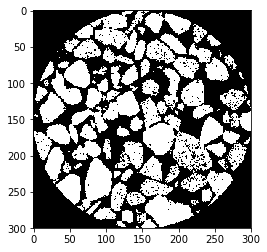

In [19]:
plt.imshow(binary[888], plt.cm.gray)

In [20]:
save_path = '/home/hasitha/Desktop/packed_img/'
tif.imsave(save_path+'gray_full_width_tube_300.tif', binary)

In [39]:
img2 = tif.imread(save_path+'gray_full_width_tube.tif')

In [40]:
img2.shape

(500, 1919, 1919)

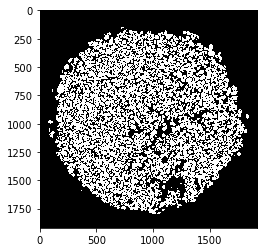

In [41]:
plt.imshow(img2[30,:,:],cmap='gray')